# Protein Macro Molecule Classification

## Project Goal

Try to predict the classifications of Proteins provided in the dataset.<br/>Apply the tools, techniques, etc. I have learnt in TOAI:
* Exploratory Data Analysis
* Feature Preprocessing
* Statistical Analysis
* Feature Engineering
* Machine learning
* Hyper parameter tuning
* Model comparisons
* Exploring the results of the model

## Brief Introduction to the dataset as well as the subject

This is a protein data set retrieved from Research Collaboratory for Structural Bioinformatics (RCSB) Protein Data Bank (PDB).<br/>
Proteins are large macromolecules, consisting of one or more long chains of amino acid residues. Proteins perform a vast array of functions within organisms.


### From Proteins to Crystals.

Scientists Isolate the DNA from different cells(human, animal, bacterial cells, etc.). Genetically modifying ecoli bacteria which acts as a factory for the protein. When putting the bacteria in to a solution of sugars they will grow, divide reproduce while being shaken in a certain temperature to speed up the process. The next laboratory instrument has beads which will sieve the proteins of different sizes. Then the purified proteins are crystalized in order to examine their shape in 3 dimensions. Another instrumnet prints proteins on plates which are kept for a few days in constant temperature.The most often used technique to investigate the structure of a protein is X-Ray Crystalography. By shining a very bright X-Ray beam generated by a CERC-Carleton. When a macromolecular crystal is irradiated with an X-ray beam, the electrons surrounding each atom in the molecule bend, or diffract, the X-ray beam. As the beam exits the crystal, the scattered X-rays produce spots, or a diffraction pattern, on a photographic film or detector behind the crystal sample. And this data gives the pattern that can be deconvoluted and interpretted mathematicaly to get the structure of the protein.

## Column Descriptions, Tools:

* **structureId**
* **classification**

  classification of structures by function.
* **experimentalTechnique**

  The experimental technique used to find the 3D structure of the protein.
* **macromoleculeType**

  macromolecule is a very large molecule, such as protein, commonly composed of the polymerization of smaller subunits called monomers. They are typically composed of thousands of atoms or more. The most common macromolecules in biochemistry are biopolymers (nucleic acids, proteins, and carbohydrates) and large non-polymeric molecules (such as lipids and macrocycles).
* **residueCount**

  All residues specified in macromolecular chains (i.e. full sequence) are counted even if not all of them are observed in the structure. The count of the possible amino acids in the sequence.

* **resolution**

  Resolution is a measure of the quality of the data that has been collected on the crystal containing the protein or nucleic acid. If all of the proteins in the crystal are aligned in an identical way, forming a very perfect crystal, then all of the proteins will scatter X-rays the same way, and the diffraction pattern will show the fine details of crystal. On the other hand, if the proteins in the crystal are all slightly different, due to local flexibility or motion, the diffraction pattern will not contain as much fine information. So resolution is a measure of the level of detail present in the diffraction pattern and the level of detail that will be seen when the electron density map is calculated.
* **structureMolecularWeight**

  All macromolecules, small molecules, and ions are included, except for water molecules. Molecular weight is calculated for all atoms, including those not observed in the experiment. Molecular weight of all non-water atoms in the asymmetric unit.
* **crystallizationMethod**
  The experimnetal method used to crystalize the macromolecule.
* **crystallizationTempK**
  The temperature at which the crystal was grown (Kelvin).
* **densityMatthews**

  The density of the crystal, expressed as the ratio of the volume of the asymmetric unit to the molecular mass of a monomer of the structure (A^3 per Dalton). Reference: Matthews, B.W. (1968). J Mol. Biol. 33, 491-497.
  Matthews coefficient probabilities: Improved estimates for unit cell contents of proteins, DNA, and protein–nucleic acid complex crystals
* **densityPercentSol**
  Density value calculated from the crystal cell dimensions and content, expressed as percent solvent.
* **pdbxDetails**

  Additional details in the Protein Database.
* **phValue**

  The pH value at which the crystal was grown.

* **publicationYear**
* **chainId**
* **sequence**

  in biology is the one-dimensional ordering of monomers, covalently linked within a biopolymer; it is also referred to as the primary structure of a biological macromolecule.



### Libraries

In [ ]:
import time
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew, kurtosis
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import sklearn
from sklearn import tree
import graphviz
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, BayesianRidge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline

### Functions

In [ ]:
def diff(list1, list2):
    return list(set(list1).symmetric_difference(set(list2)))
    
def find_dtype_col(df):
  numeric_cols = list(df.select_dtypes(include=[np.number]).columns.values)
  col_list = list(df.columns)
  categ_cols = diff(col_list, numeric_cols)

  return numeric_cols, categ_cols

def categ_cardinality(df, categ_cols):
  for col in categ_cols:
    cardinality = len(pd.Index(df[col]).value_counts())
    print(df[col].name + ": " + str(cardinality))

def ph_labels(val):
  if val == 7 or np.isnan(val):
    return 'Neutral'
  elif val < 7:
    return 'Acid'
  else:
    return 'Base'

In [ ]:
def pie_plot(labels, sizes, colors, title):
  fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(aspect="equal"))
  wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, shadow=True, autopct='%1.1f%%', startangle=140)
  ax.set_title(title, fontsize=18, weight="bold", color='black')
  plt.setp(autotexts, size=15, weight="bold")
  plt.setp(texts, size=15, weight="bold")
  plt.show()

def count_plot_categ(categ, df, palette, values, title, hue=None, hue_order=None):
  ax = sns.countplot(y=categ, data=df, palette=palette, order=values, hue=hue, hue_order=hue_order)
  ax.yaxis.label.set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.set_title(title)

def line_plot(x, y, df, title):
  fig = plt.figure(figsize=(20,10), dpi= 80)
  ax = sns.lineplot(x=x, y=y, data=df)
  ax.set_title(title, fontsize=18, weight="bold", color='black')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  return plt.show()

def bar_plot_cas(categ, df, x_label, title):
  ax = sns.countplot(y=categ, data=df)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.tick_params(length =3,labelsize=11,color='black')
  ax.set_xlabel(x_label,color='black',fontsize=13)
  ax.set_title(title,fontsize=14,color='black')

def box_plot(x, y, data, title):
  ax = sns.boxplot(x=x, y=y, data=data)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.set_title(title,fontsize=14,color='black')

def stackedHist(df, title, ylabel):
  fig = plt.figure(figsize=(20,10), dpi= 80)
  ax = fig.add_subplot(111)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.tick_params(length =3,labelsize=11,color='black')
  ax.set_ylabel(ylabel,color='black',fontsize=13)
  ax.set_title(title, fontsize=20,color='black')
  ph_plot_df.plot(kind='bar', stacked=True, ax=ax, fig=fig)

def lmplot(df, x, y, col, title):
  # Each line in its own column
  fig = plt.figure(figsize=(20,10), dpi= 80)
  sns.set_style("white")
  ax = sns.lmplot(x=x, y=y, 
                     data=df, 
                     height=7, 
                     robust=True, 
                     palette='Set1', 
                     col=col,
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))
  
  ax.fig.subplots_adjust(top=0.9)
  ax.fig.suptitle(title, fontsize=20,color='black')

  return plt.show()

def plot_miss(df):
  df_isnull = pd.DataFrame(round((df.isnull().sum().sort_values(ascending=False)/df.shape[0])*100,1)).reset_index()
  df_isnull.columns = ['Columns', '% of Missing Data']
  df_isnull.style.format({'% of Missing Data': lambda x:'{:.2f}'.format(abs(x))})
  cm = sns.light_palette("skyblue", as_cmap=True)
  df_isnull = df_isnull.style.background_gradient(cmap=cm)
  df_isnull = df_isnull.set_precision(1)
  return df_isnull

In [ ]:
def corr_matrix(df):
  colormap = plt.cm.RdBu
  f, ax = plt.subplots(figsize=(18,10))
  sns.heatmap(df.corr(),cmap= colormap,annot=True,ax=ax,annot_kws ={'fontsize':12})
  kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':13}
  ax.tick_params(**kwargs)
  ax.tick_params(**kwargs,axis='x')
  plt.title ('Pearson Correlation Matrix', color = 'black',fontsize=18)
  plt.tight_layout()
  plt.show()
  
def stat_kde_plot(df, input1,input2,input3,input4, input5):
  f, (ax1,ax2,ax3, ax4, ax5) = plt.subplots(1,5,figsize=(28,5))
  sns.kdeplot(df[input1],ax = ax1,color ='blue',shade=True,
              label=("Skewness : %.2f"%(df[input1].skew()),
                     "Kurtosis: %.2f"%(df[input1].kurtosis())))
  sns.kdeplot(df[input2], ax = ax2,color='r',shade=True,
              label=("Skewness : %.2f"%(df[input2].skew()),
                     "Kurtosis: %.2f"%(df[input2].kurtosis())))
  sns.kdeplot(df[input3], ax = ax3,color='gray',shade=True,
              label=("Skewness : %.2f"%(df[input3].skew()),
                     "Kurtosis: %.2f"%(df[input3].kurtosis())))
  sns.kdeplot(df[input4],ax = ax4,color ='forestgreen',shade=True,
              label=("Skewness : %.2f"%(df[input4].skew()),
                     "Kurtosis: %.2f"%(df[input4].kurtosis())))
  sns.kdeplot(df[input5],ax = ax5,color ='forestgreen',shade=True,
              label=("Skewness : %.2f"%(df[input5].skew()),
                      "Kurtosis: %.2f"%(df[input5].kurtosis())))
  axes = [ax1,ax2,ax3,ax4, ax5]
  input = [input1,input2,input3,input4, input5]
  for j in range(len(axes)):
    axes[j].set_xlabel(input[j],color='black',fontsize=12)
    axes[j].set_title(input[j] + ' Kdeplot',fontsize=14)
    axes[j].axvline(df[input[j]].mean() , color ='g',linestyle = '--')
    axes[j].legend(loc ='upper right',fontsize=12,ncol=2)
  sns.despine()
  return plt.show()
    
def stat_plot (df, input):
  (mu, sigma) = norm.fit(df[input])
  f, (ax1, ax2)= plt.subplots(1,2,figsize=(15,5))
  # Apply the log transformation on the column
  sns.distplot(df[input],ax = ax1,fit=norm,color ='blue',hist=False)
  ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
  ax1.set_ylabel('Frequency')
  ax1.set_title(input +' Distribution',color='black',fontsize=14)
  #Get also the QQ-plot
  res = stats.probplot(df[input], plot=ax2)
  sns.despine()
  return plt.show()
  #Credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

# Compute confusion matrix
def single_model(model):
  clf = model
  clf.fit(protein_prepared_train,y_train)
  y_pred = clf.predict(protein_prepared_valid)
  conf_mx = confusion_matrix(y_pred,y_val)
  return conf_mx

def model_score(classifier, prepared_train, y_train, prepared_valid, y_val):
  classifier.fit(prepared_train, y_train)
  y_pred = classifier.predict(prepared_valid)

  return accuracy_score(y_val, y_pred)
  
def sing_model(model,input):
  feat_importances = pd.Series(model.feature_importances_, index=dummy_train.columns)
  feat_importances = feat_importances.reset_index()
  feat_importances.columns = ['Feature', 'Importance']
  f, ax = plt.subplots(figsize=(10,8))
  sns.barplot('Importance','Feature',data=feat_importances.nlargest(15, 'Importance'), ax=ax,palette='RdBu_r',edgecolor=".2")
  for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.002, i.get_y()+.45, \
            str(round((i.get_width()), 5)), fontsize=12, color='black') 
  kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'large'}
  ax.tick_params(**kwargs)
  x_axis = ax.axes.get_xaxis().set_visible(False)
  ax.set_title(input +':'+ ' Features Importance Score',fontsize=16)
  sns.despine(bottom=True)
  return plt.show()

#plot confusion matrix    
def plot_confusion_matrix(cm, classes,model_name):
  plt.figure(figsize=(10,6))
  cmap = plt.cm.Blues
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title('Confusion matrix: '+ model_name, fontsize=15)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=0)
  plt.yticks(tick_marks, classes)
  fmt = 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=12)

  plt.tight_layout()
  plt.ylabel('True label',fontsize=12,color='black')
  plt.xlabel('Predicted label',fontsize=12,color='black' )
  np.set_printoptions(precision=2)
    
  return plt.show()

def plot_model_scores(model_scores, classifier):
  classifier_scores_df = pd.DataFrame(model_scores,classifier).reset_index()
  classifier_scores_df.columns=['model','accuracy_score']
  classifier_scores_df.sort_values('accuracy_score',ascending = False,inplace=True)
  classifier_scores_df.reset_index(drop=True,inplace = True)
  f, ax = plt.subplots(figsize=(10,8))
  sns.barplot('accuracy_score','model',data=classifier_scores_df, ax=ax, palette='RdBu_r',edgecolor=".2")
  for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.01, i.get_y()+.55, \
        str(round((i.get_width()), 2)), fontsize=12, color='black') 
  kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'large'}
  ax.tick_params(**kwargs)
  x_axis = ax.axes.get_xaxis().set_visible(False)
  ax.set_title('Model & Accuracy Score',fontsize=16)
  sns.despine(bottom=True)
  return plt.show()

## Exploratory Data Analysis, Preprocessing:

### Loading the datasets and taking a look at it.

In [ ]:
df_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TOAI ML Project/pdb_data_no_dups.csv')
df_seq = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TOAI ML Project/pdb_data_seq.csv')

In [ ]:
df_data

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141396,9RUB,LYASE(CARBON-CARBON),X-RAY DIFFRACTION,Protein,932,2.60,101838.68,NaN,NaN,2.38,48.29,NaN,NaN,1991.0
141397,9TNA,T-RNA,X-RAY DIFFRACTION,NaN,0,NaN,24244.34,NaN,NaN,3.17,61.18,NaN,NaN,1986.0
141398,9WGA,LECTIN (AGGLUTININ),X-RAY DIFFRACTION,Protein,342,1.80,34270.22,NaN,NaN,2.50,50.76,NaN,NaN,1990.0
141399,9XIA,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,388,1.90,43542.29,NaN,NaN,2.79,55.93,NaN,NaN,1989.0


In [ ]:
df_seq

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
...,...,...,...,...,...
467299,9XIA,A,MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...,388,Protein
467300,9XIM,A,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...,1572,Protein
467301,9XIM,B,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...,1572,Protein
467302,9XIM,C,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...,1572,Protein


### Merging the Datasets

In [ ]:
full_df = df_data.merge(df_seq,how='inner',on='structureId')

In [ ]:
full_df.shape

(471149, 18)

In [ ]:
full_df

,structureId,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,residueCount_y,macromoleculeType_y
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG,24,DNA
3,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,B,CGCGAATTCGCG,24,DNA
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471144,9XIA,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,388,1.90,43542.29,NaN,NaN,2.79,55.93,NaN,NaN,1989.0,A,MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...,388,Protein
471145,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.40,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,A,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...,1572,Protein
471146,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.40,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,B,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...,1572,Protein
471147,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.40,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,C,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...,1572,Protein


**Cleaning up duplicate columns from merging the datasets**

In [ ]:
print(full_df['macromoleculeType_x'].equals(full_df['macromoleculeType_y']))
print(full_df['residueCount_x'].equals(full_df['residueCount_y']))

True
True


In [ ]:
full_df = full_df.drop(labels=['macromoleculeType_y', 'residueCount_y'], axis=1)
full_df = full_df.rename(columns={"macromoleculeType_x": "macromoleculeType", "residueCount_x": "residueCount"})

In [ ]:
print(full_df.structureId.duplicated().value_counts())

True     330899
False    140250
Name: structureId, dtype: int64


**We have quite a few (330899) similar macro molecules in our merged dataframe, as a lot of structures have some properties that differ slightly.**

**Creating another dataset with proteins of unique structure IDs.**

In [ ]:
unique_df = full_df[~full_df.structureId.duplicated()].reset_index(drop=True)
unique_df

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0,A,CGCAAATTTGCG
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140245,9RSA,HYDROLASE (PHOSPHORIC DIESTER),X-RAY DIFFRACTION,Protein,248,1.80,27987.16,NaN,NaN,2.25,45.45,NaN,NaN,1990.0,A,KETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTF...
140246,9RUB,LYASE(CARBON-CARBON),X-RAY DIFFRACTION,Protein,932,2.60,101838.68,NaN,NaN,2.38,48.29,NaN,NaN,1991.0,A,MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFA...
140247,9WGA,LECTIN (AGGLUTININ),X-RAY DIFFRACTION,Protein,342,1.80,34270.22,NaN,NaN,2.50,50.76,NaN,NaN,1990.0,A,ERCGEQGSNMECPNNLCCSQYGYCGMGGDYCGKGCQNGACWTSKRC...
140248,9XIA,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,388,1.90,43542.29,NaN,NaN,2.79,55.93,NaN,NaN,1989.0,A,MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...


### Describing the Data.

In [ ]:
full_df.describe(include='all')

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
count,471149,471145,471149,435379,471149.00000,449486.000000,4.711490e+05,314754,317697.000000,389645.000000,389768.000000,385468,340694.000000,413513.000000,471139,471121
unique,140250,4989,32,13,NaN,NaN,NaN,546,NaN,NaN,NaN,90933,NaN,NaN,2836,104812
top,3J3Q,RIBOSOME,X-RAY DIFFRACTION,Protein,NaN,NaN,NaN,"VAPOR DIFFUSION, HANGING DROP",NaN,NaN,NaN,"PEG 20K, KSCN, Mg Acetate, Tris-Acetate, Glyce...",NaN,NaN,A,PIVQNLQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEG...
freq,1356,60710,405579,346325,NaN,NaN,NaN,167555,NaN,NaN,NaN,3709,NaN,NaN,135653,5112
mean,NaN,NaN,NaN,NaN,6257.93182,3.020658,9.261153e+05,NaN,290.889746,2.850779,54.198949,NaN,6.830608,2010.483702,NaN,NaN
std,NaN,NaN,NaN,NaN,23618.38381,3.091223,3.018842e+06,NaN,8.785254,0.824394,10.269884,NaN,2.461778,6.997897,NaN,NaN
min,NaN,NaN,NaN,NaN,0.00000,0.480000,4.535500e+02,NaN,4.000000,0.000000,0.000000,NaN,0.000000,201.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,456.00000,2.000000,5.276684e+04,NaN,291.000000,2.320000,46.890000,NaN,6.100000,2007.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,1140.00000,2.500000,1.311385e+05,NaN,293.000000,2.670000,53.950000,NaN,7.000000,2012.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,4528.00000,3.100000,6.353231e+05,NaN,295.000000,3.190000,61.370000,NaN,7.500000,2015.000000,NaN,NaN


### Missing Data

In [ ]:
plot_miss(full_df)

,Columns,% of Missing Data
0,crystallizationMethod,33.2
1,crystallizationTempK,32.6
2,phValue,27.7
3,pdbxDetails,18.2
4,densityMatthews,17.3
5,densityPercentSol,17.3
6,publicationYear,12.2
7,macromoleculeType,7.6
8,resolution,4.6
9,sequence,0.0


### Data Types

In [ ]:
full_df.dtypes

structureId                  object
classification               object
experimentalTechnique        object
macromoleculeType            object
residueCount                  int64
resolution                  float64
structureMolecularWeight    float64
crystallizationMethod        object
crystallizationTempK        float64
densityMatthews             float64
densityPercentSol           float64
pdbxDetails                  object
phValue                     float64
publicationYear             float64
chainId                      object
sequence                     object
dtype: object

In [ ]:
numeric_cols, categ_cols = find_dtype_col(full_df)
categ_cols.remove('classification')
target_col = ['classification']
print('Numeric columns: ', numeric_cols)
print('Categorical columns: ', categ_cols)
print('Target columns: ', target_col)

Numeric columns:  ['residueCount', 'resolution', 'structureMolecularWeight', 'crystallizationTempK', 'densityMatthews', 'densityPercentSol', 'phValue', 'publicationYear']
Categorical columns:  ['structureId', 'sequence', 'macromoleculeType', 'experimentalTechnique', 'pdbxDetails', 'chainId', 'crystallizationMethod']
Target columns:  ['classification']


### Categorical data cardinality

In [ ]:
categ_cardinality(full_df, categ_cols+target_col)

structureId: 140250
sequence: 104812
macromoleculeType: 13
experimentalTechnique: 32
pdbxDetails: 90933
chainId: 2836
crystallizationMethod: 546
classification: 4989


In [ ]:
full_df

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG
1,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,B,CCGGCGCCGG
2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG
3,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,B,CGCGAATTCGCG
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471144,9XIA,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,388,1.90,43542.29,NaN,NaN,2.79,55.93,NaN,NaN,1989.0,A,MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...
471145,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.40,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,A,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471146,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.40,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,B,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471147,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.40,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,C,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...


## Visualizing the Data, Exploring the Data further:

### PH values

In [ ]:
ph_plot_df = full_df.dropna(subset=['phValue'])

In [ ]:
base = ph_plot_df['phValue'].where(ph_plot_df['phValue']>7).value_counts().sum()
acid = ph_plot_df['phValue'].where(ph_plot_df['phValue']<7).value_counts().sum()
neutral = ph_plot_df['phValue'].where(ph_plot_df['phValue']==7).value_counts().sum()
print('Base: ' + str(base))
print('Neutral: '+ str(neutral))
print('Acid: '+ str(acid))

Base: 140369
Neutral: 43192
Acid: 157133


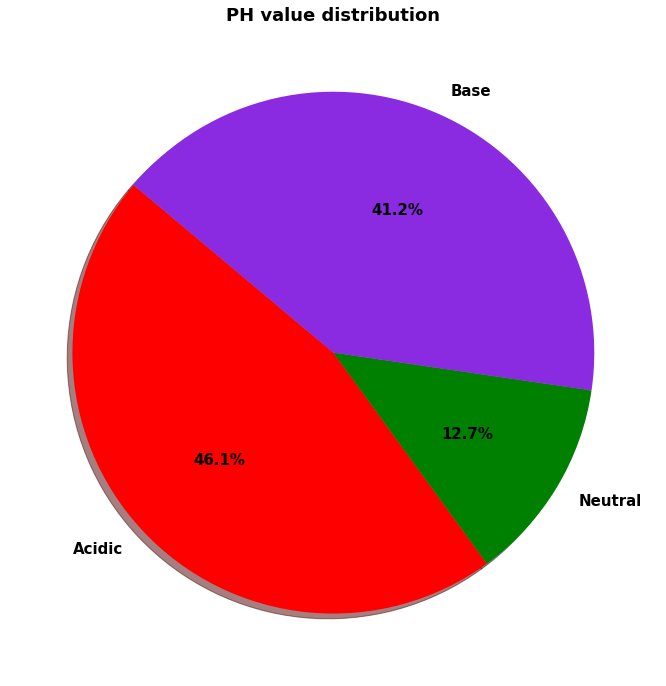

In [ ]:
labels = ['Acidic', 'Neutral', 'Base']
sizes = [acid, neutral, base]
colors = ['red', 'green', 'blueviolet']
pie_plot(labels, sizes, colors, 'PH value distribution')

In [ ]:
ph_plot_df['phValueRounded'] = ph_plot_df['phValue'].round()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
top_classif = ph_plot_df.classification.value_counts().iloc[:7].index.to_list()
class_filter = ph_plot_df['classification'].isin(top_classif)
ph_plot_df = ph_plot_df[class_filter]


In [ ]:
ph_plot_df = ph_plot_df.groupby(['classification', 'phValueRounded']).size().reset_index().pivot(columns='classification', index='phValueRounded', values=0)

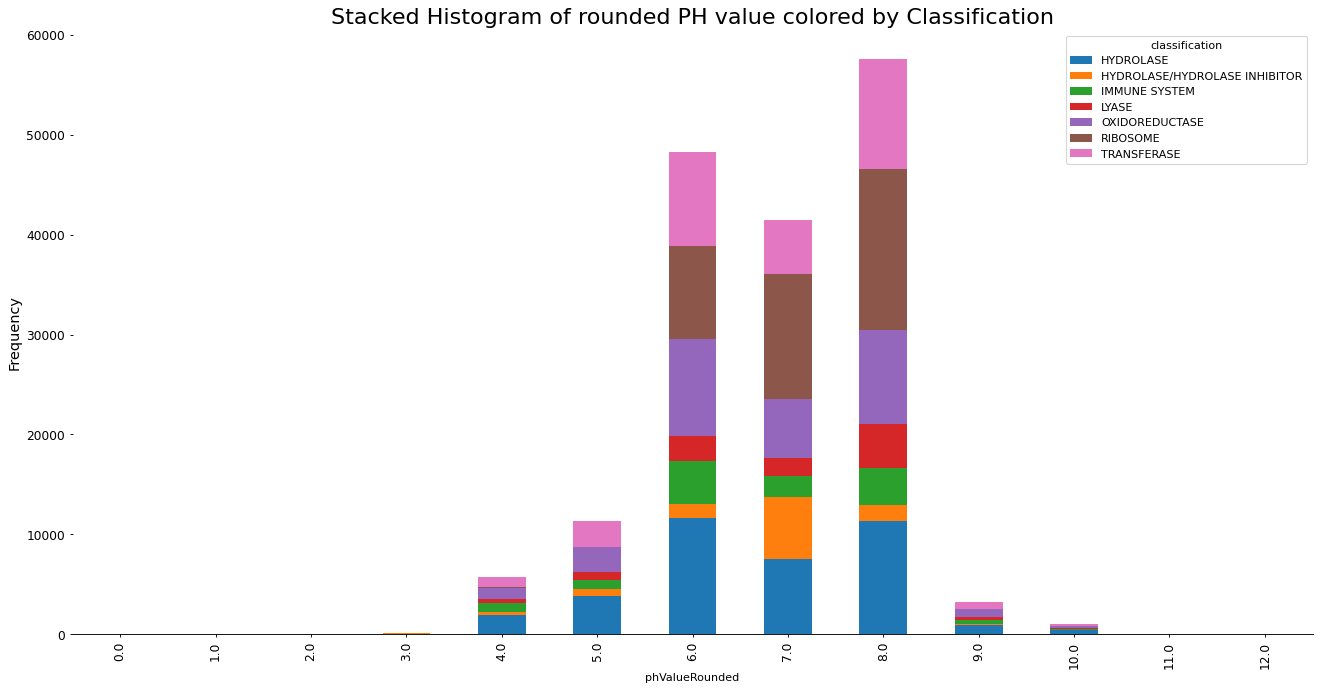

In [ ]:
stackedHist(ph_plot_df, 'Stacked Histogram of rounded PH value colored by Classification', 'Frequency')

* **Most of the values are among 6, 7, 8 PH.**

* **There is not much deviation from the neutral PH value.**

* **While the PH values for the most common classifications are fairly balanced.**

### Classifications:

In [ ]:
classes = full_df.groupby(by='classification').size().sort_values(ascending=False)
print(classes[:10])

classification
RIBOSOME                         60710
HYDROLASE                        47833
TRANSFERASE                      37726
OXIDOREDUCTASE                   35114
IMMUNE SYSTEM                    15989
LYASE                            11871
HYDROLASE/HYDROLASE INHIBITOR    11262
VIRUS                            10832
TRANSCRIPTION                    10564
VIRAL PROTEIN                     8875
dtype: int64


**The Top 10 Macro Molecule Classifications take up over Half of the dataset.**

In [ ]:
full_df.classification.value_counts().iloc[:10].sum()/full_df.shape[0]*100

53.22647400291628

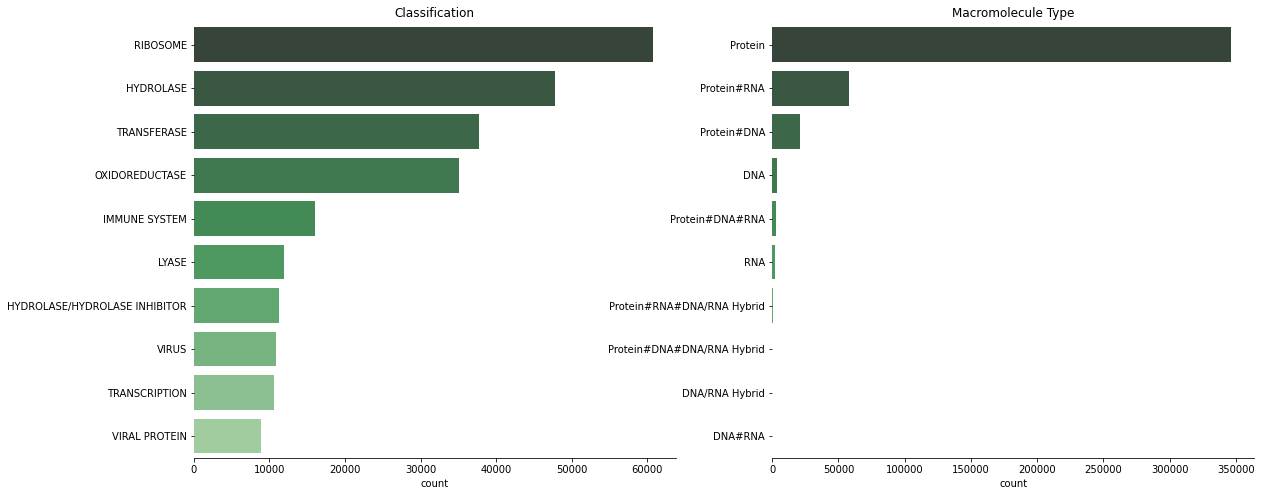

In [ ]:
plt.figure(figsize=(19,8))
plt.subplot(1,2,1)
count_plot_categ("classification", full_df, "Greens_d", full_df.classification.value_counts().iloc[:10].index, "Classification")
plt.subplot(1, 2, 2)
count_plot_categ("macromoleculeType", full_df, "Greens_d", full_df.macromoleculeType.value_counts().iloc[:10].index, "Macromolecule Type")


#### Insights
* **We have a lot of under represented classes as the top 10 Classifications take up more than half of the dataset(53%).** <br/>
* **Also to see whether there is target leakage in Macromolecule type for the top classifications. As in the full data there are some leakages between these two columns.**

In [ ]:
df_select = full_df.loc[full_df.classification.isin(classes.index.tolist()[:4]), :]

### Top 4 Classification types mapped by Density Matthews and Density Percent Solvent

<Figure size 1600x800 with 0 Axes>

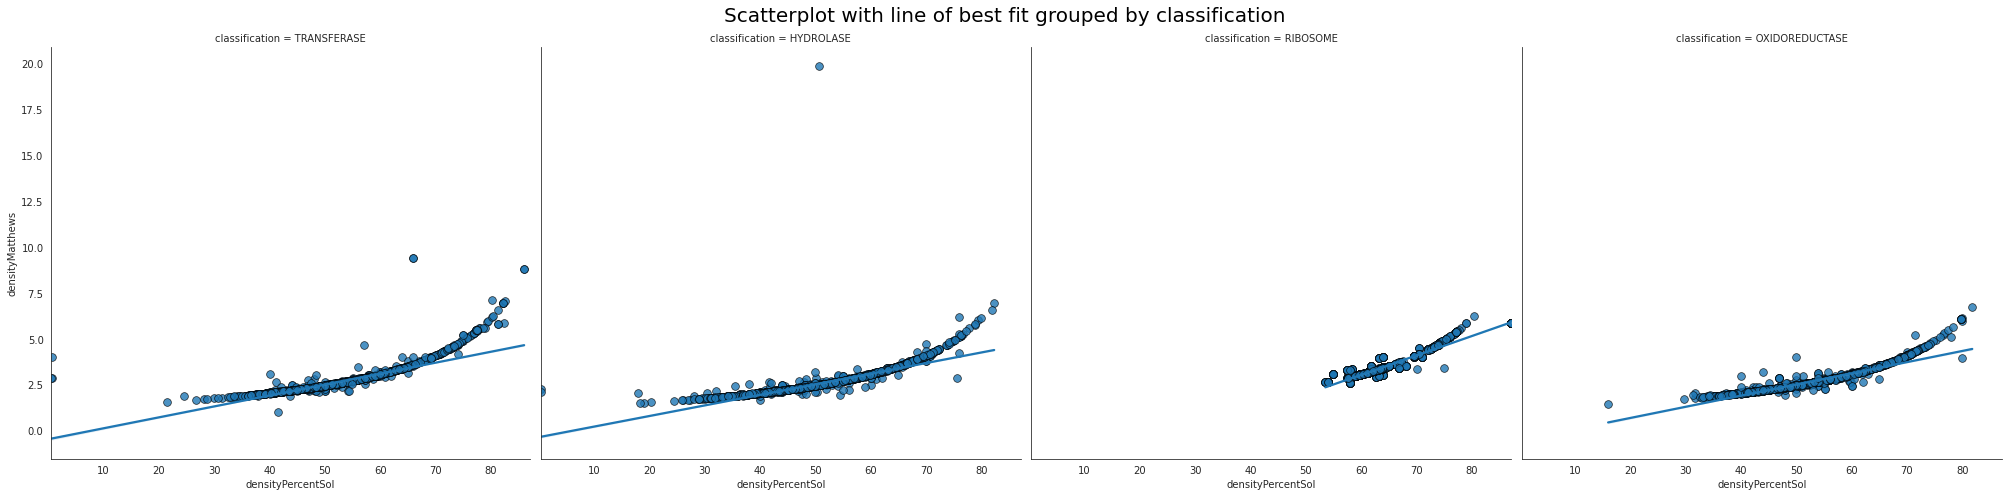

In [ ]:
df_sample = df_select.sample(10000)
lmplot(df_sample, 'densityPercentSol', 'densityMatthews', 'classification', 'Scatterplot with line of best fit grouped by classification')

* **The Scatterplots show the correlation between densityMatthews and densityPercentSol for the 4 most common classifications in the dataset.**
* **We can see a clear pattern for each classification.**
* **The patterns in between the graphs are similar except for Ribosome.**

### Crystalization Method and Temperature in Kelvins

In [ ]:
df_select = full_df.dropna(subset=['crystallizationMethod', 'crystallizationTempK'])

In [ ]:
crystal_methods = df_select.crystallizationMethod.value_counts()
crystal_temperatures = df_select.crystallizationTempK.value_counts()
df_select_top_crystal_methods=df_select.loc[df_select.crystallizationMethod.isin(crystal_methods.index.tolist()[:4]), :]
df_select_top_crystal_methods

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
5,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0,A,CGCAAATTTGCG
6,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0,B,CGCAAATTTGCG
45,110D,DNA,X-RAY DIFFRACTION,DNA,6,1.90,2337.73,"VAPOR DIFFUSION, SITTING DROP",277.0,2.90,57.63,"pH 6.60, VAPOR DIFFUSION, SITTING DROP, temper...",6.6,1993.0,A,CGGCCG
48,111D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.0,2.29,46.25,"pH 6.60, VAPOR DIFFUSION, SITTING DROP, temper...",6.6,1989.0,A,CGCAAATTGGCG
49,111D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.0,2.29,46.25,"pH 6.60, VAPOR DIFFUSION, SITTING DROP, temper...",6.6,1989.0,B,CGCAAATTGGCG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470659,7BNA,DNA,X-RAY DIFFRACTION,DNA,24,1.90,7326.78,VAPOR DIFFUSION,290.0,2.27,45.79,"pH 7.50, VAPOR DIFFUSION, temperature 290.00K",7.5,1985.0,B,CGCGAATTCGCG
470853,8BNA,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7775.59,VAPOR DIFFUSION,277.0,2.27,45.79,"VAPOR DIFFUSION, temperature 277.00K",NaN,1987.0,A,CGCGAATTCGCG
470854,8BNA,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7775.59,VAPOR DIFFUSION,277.0,2.27,45.79,"VAPOR DIFFUSION, temperature 277.00K",NaN,1987.0,B,CGCGAATTCGCG
471022,9BNA,DNA,X-RAY DIFFRACTION,DNA,24,1.90,7326.78,VAPOR DIFFUSION,290.0,2.27,45.79,"VAPOR DIFFUSION, temperature 290.00K",NaN,1987.0,A,CGCGAATTCGCG


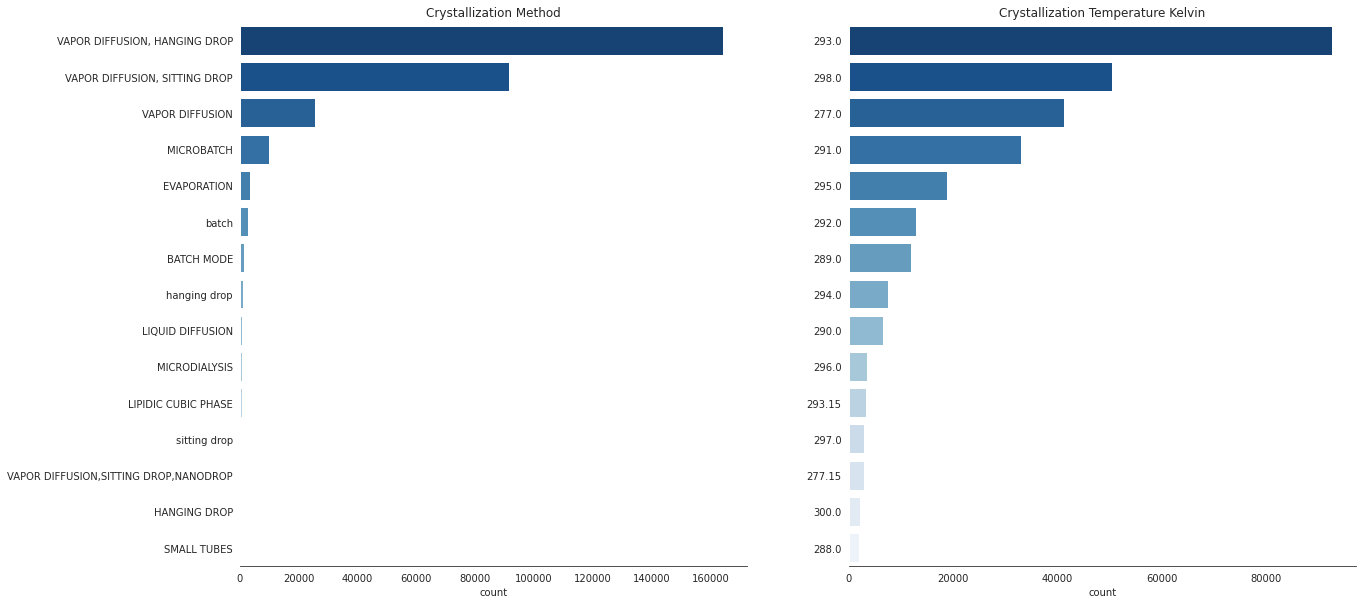

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
count_plot_categ("crystallizationMethod", df_select, "Blues_r", crystal_methods.iloc[:15].index, "Crystallization Method")
plt.subplot(1,2,2)
count_plot_categ("crystallizationTempK", df_select, "Blues_r", crystal_temperatures.iloc[:15].index, "Crystallization Temperature Kelvin")

### Looking at the Temperatures of the most represented Crystalization Methods.

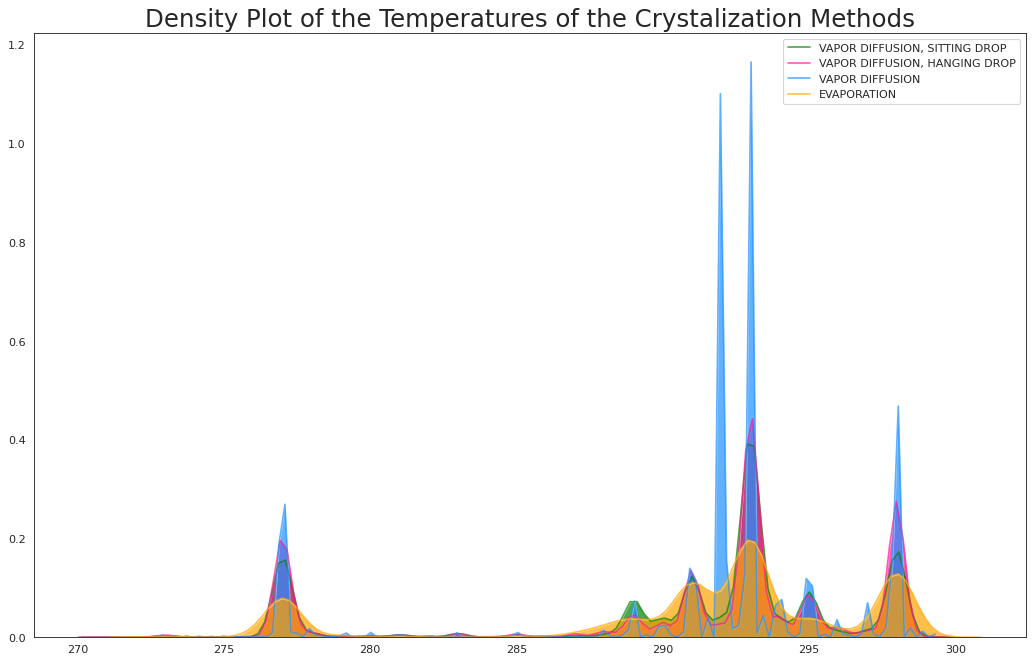

In [ ]:
# BBD
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(df_select.loc[df_select['crystallizationMethod'] == 'VAPOR DIFFUSION, SITTING DROP', "crystallizationTempK"], shade=True, color="g", label="VAPOR DIFFUSION, SITTING DROP", alpha=.7, clip=[270,300])
sns.kdeplot(df_select.loc[df_select['crystallizationMethod'] == 'VAPOR DIFFUSION, HANGING DROP', "crystallizationTempK"], shade=True, color="deeppink", label="VAPOR DIFFUSION, HANGING DROP", alpha=.7, clip=[270,300])
sns.kdeplot(df_select.loc[df_select['crystallizationMethod'] == 'VAPOR DIFFUSION', "crystallizationTempK"], shade=True, color="dodgerblue", label="VAPOR DIFFUSION", alpha=.7,  clip=[270,300])
sns.kdeplot(df_select.loc[df_select['crystallizationMethod'] == 'EVAPORATION', "crystallizationTempK"], shade=True, color="orange", label="EVAPORATION", alpha=.7, clip=[270,300])

# Decoration
plt.title('Density Plot of the Temperatures of the Crystalization Methods', fontsize=22)
plt.legend()
plt.show()

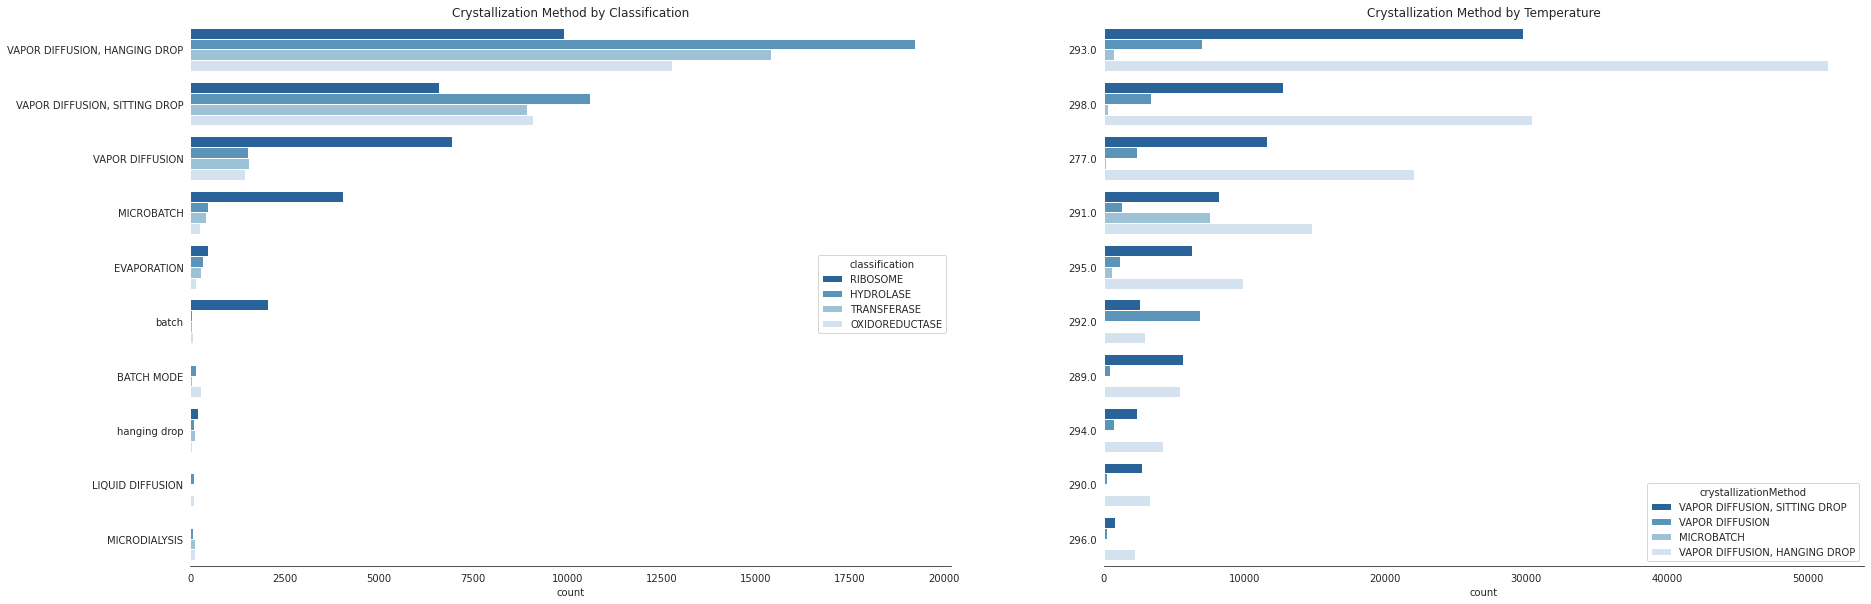

In [ ]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
count_plot_categ("crystallizationMethod", df_select, "Blues_r", crystal_methods.iloc[:10].index, "Crystallization Method by Classification", hue='classification', hue_order=classes.index[:4])
plt.subplot(1,2,2)
count_plot_categ("crystallizationTempK", df_select_top_crystal_methods, "Blues_r", crystal_temperatures.iloc[:10].index, "Crystallization Method by Temperature", hue='crystallizationMethod')


In [ ]:
crystal_methods.index.tolist()[:15]

['VAPOR DIFFUSION, HANGING DROP',
 'VAPOR DIFFUSION, SITTING DROP',
 'VAPOR DIFFUSION',
 'MICROBATCH',
 'EVAPORATION',
 'batch',
 'BATCH MODE',
 'hanging drop',
 'LIQUID DIFFUSION',
 'MICRODIALYSIS',
 'LIPIDIC CUBIC PHASE',
 'sitting drop',
 'VAPOR DIFFUSION,SITTING DROP,NANODROP',
 'HANGING DROP',
 'SMALL TUBES']

In [ ]:
aaa = df_select.loc[df_select.crystallizationMethod.isin(crystal_methods.index.tolist()[:7]), :]
aaa

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
5,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0,A,CGCAAATTTGCG
6,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0,B,CGCAAATTTGCG
45,110D,DNA,X-RAY DIFFRACTION,DNA,6,1.90,2337.73,"VAPOR DIFFUSION, SITTING DROP",277.0,2.90,57.63,"pH 6.60, VAPOR DIFFUSION, SITTING DROP, temper...",6.6,1993.0,A,CGGCCG
48,111D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.0,2.29,46.25,"pH 6.60, VAPOR DIFFUSION, SITTING DROP, temper...",6.6,1989.0,A,CGCAAATTGGCG
49,111D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7374.83,"VAPOR DIFFUSION, SITTING DROP",277.0,2.29,46.25,"pH 6.60, VAPOR DIFFUSION, SITTING DROP, temper...",6.6,1989.0,B,CGCAAATTGGCG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470659,7BNA,DNA,X-RAY DIFFRACTION,DNA,24,1.90,7326.78,VAPOR DIFFUSION,290.0,2.27,45.79,"pH 7.50, VAPOR DIFFUSION, temperature 290.00K",7.5,1985.0,B,CGCGAATTCGCG
470853,8BNA,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7775.59,VAPOR DIFFUSION,277.0,2.27,45.79,"VAPOR DIFFUSION, temperature 277.00K",NaN,1987.0,A,CGCGAATTCGCG
470854,8BNA,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7775.59,VAPOR DIFFUSION,277.0,2.27,45.79,"VAPOR DIFFUSION, temperature 277.00K",NaN,1987.0,B,CGCGAATTCGCG
471022,9BNA,DNA,X-RAY DIFFRACTION,DNA,24,1.90,7326.78,VAPOR DIFFUSION,290.0,2.27,45.79,"VAPOR DIFFUSION, temperature 290.00K",NaN,1987.0,A,CGCGAATTCGCG


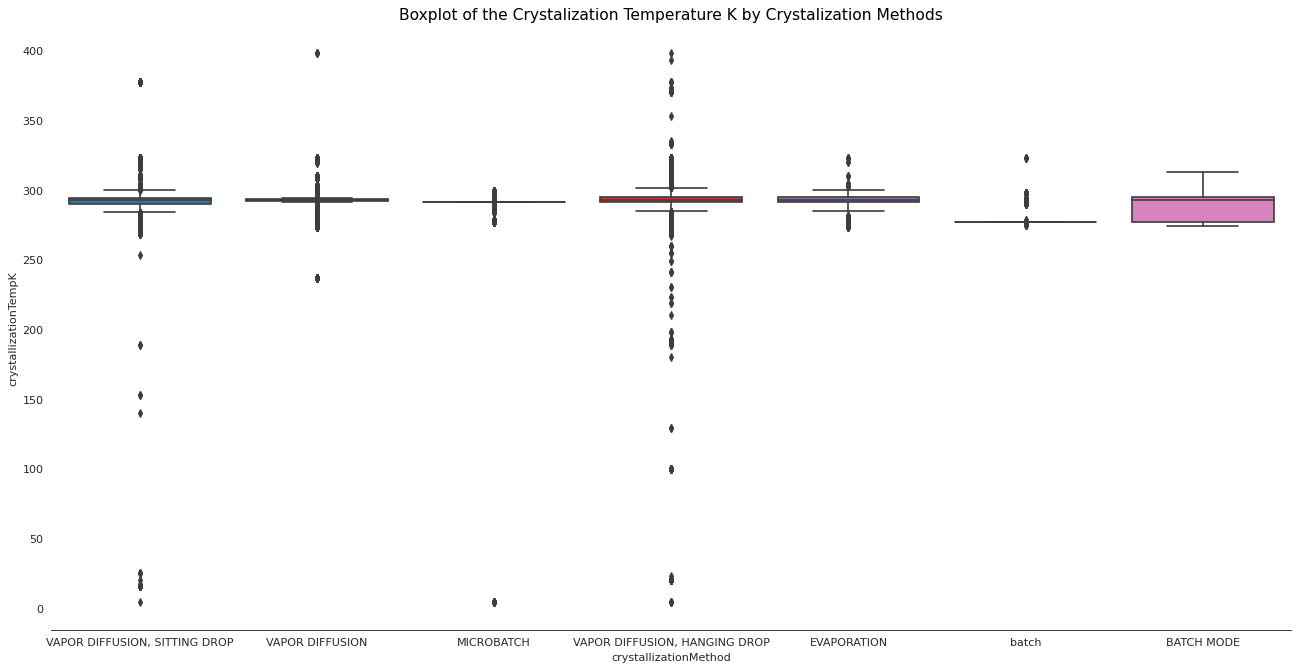

In [ ]:
plt.figure(figsize=(20,10), dpi= 80)
plt.subplot(1,1,1)
box_plot('crystallizationMethod', 'crystallizationTempK', df_select.loc[df_select.crystallizationMethod.isin(crystal_methods.index.tolist()[:7]), :], 'Boxplot of the Crystalization Temperature K by Crystalization Methods')

* **Non-normal distribution**
* **A lot of outliers**


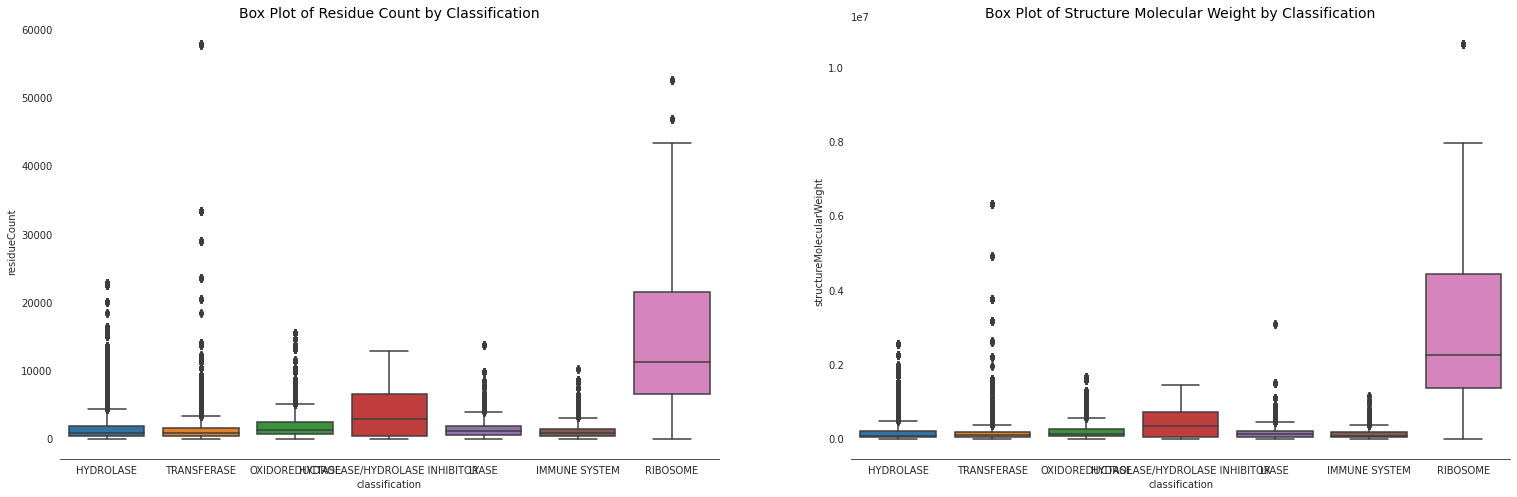

In [ ]:
# Draw Plot
plt.figure(figsize=(26,8))
plt.subplot(1,2,1)
box_plot('classification', 'residueCount', full_df.loc[full_df.classification.isin(classes.index.tolist()[:7]), :], 'Box Plot of Residue Count by Classification')
plt.subplot(1,2,2)
box_plot('classification', 'structureMolecularWeight', full_df.loc[full_df.classification.isin(classes.index.tolist()[:7]), :], 'Box Plot of Structure Molecular Weight by Classification')


### Publication Year, Resolution

In [ ]:
pub_year_df = full_df['publicationYear'].where(full_df['publicationYear']>1900).value_counts().reset_index()
pub_year_df = pub_year_df.rename(columns={'index':'Publication Year', 'publicationYear':'Publications'})

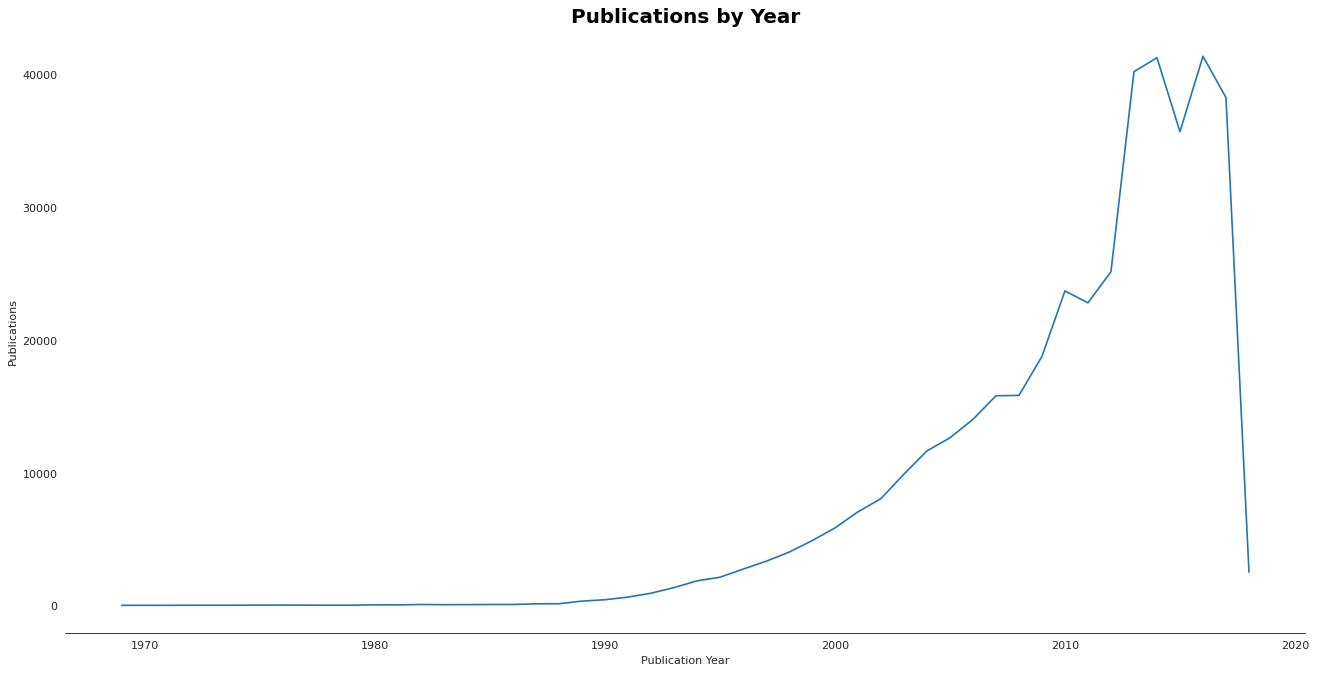

In [ ]:
 line_plot('Publication Year', "Publications", pub_year_df, 'Publications by Year')

In [ ]:
df_year_resolution = full_df.dropna(subset=['resolution', 'publicationYear'])

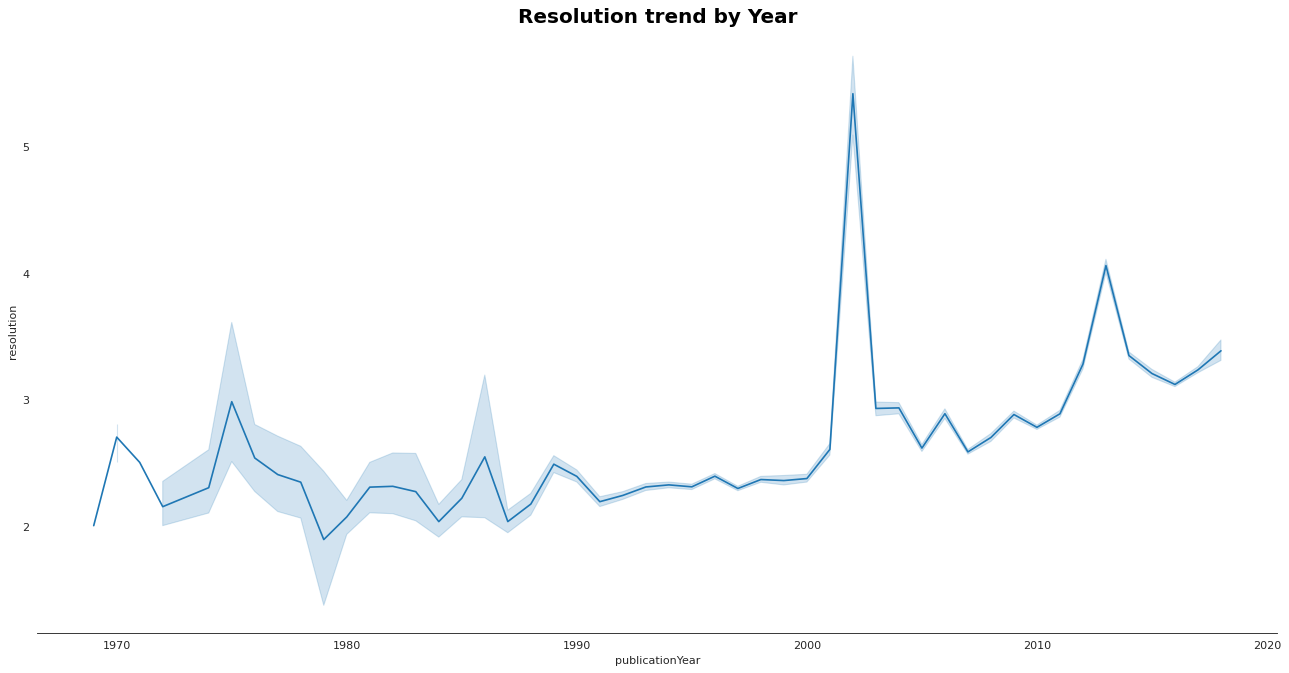

In [ ]:
line_plot('publicationYear', "resolution", df_year_resolution, 'Resolution trend by Year')

### Incorrect value in the data

In [ ]:
full_df['publicationYear'].where(full_df['publicationYear']<1900).value_counts()

201.0    2
Name: publicationYear, dtype: int64

In [ ]:
filter = full_df['publicationYear'] == 201.0
full_df[filter] = 2010.0

**PDP Started in 1969.**


### Experimental Technique

In [ ]:
exp = full_df.experimentalTechnique.value_counts()
exp

X-RAY DIFFRACTION                                            405579
ELECTRON MICROSCOPY                                           49118
SOLUTION NMR                                                  15259
SOLID-STATE NMR                                                 447
ELECTRON CRYSTALLOGRAPHY                                        151
SOLUTION SCATTERING                                              97
NEUTRON DIFFRACTION                                              89
SOLID-STATE NMR, ELECTRON MICROSCOPY                             78
FIBER DIFFRACTION                                                59
NEUTRON DIFFRACTION, X-RAY DIFFRACTION                           50
X-RAY DIFFRACTION, NEUTRON DIFFRACTION                           41
POWDER DIFFRACTION                                               32
ELECTRON MICROSCOPY, SOLUTION SCATTERING, SOLID-STATE NMR        24
SOLUTION SCATTERING, SOLUTION NMR                                19
ELECTRON MICROSCOPY, SOLID-STATE NMR            

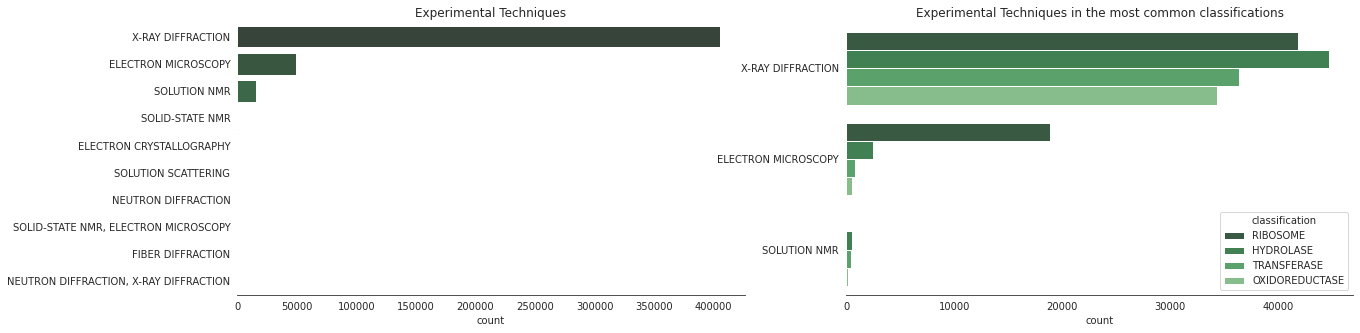

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
count_plot_categ("experimentalTechnique", full_df, "Greens_d", exp.iloc[:10].index, "Experimental Techniques")
plt.subplot(1,2,2)
count_plot_categ("experimentalTechnique", full_df, "Greens_d", exp.iloc[:3].index, "Experimental Techniques in the most common classifications", hue='classification', hue_order=classes.index[:4])

## Further data preprocessing(missing values, etc) and Feature Engineering

### Working with (the most represented) part in this dataset

In [ ]:
#Leaving proteins and dropping underrepresented classifications
mol_type = ['Protein', 'Protein#RNA', 'Protein#DNA']
exp_type = exp.index.tolist()[:3]
classif = classes.index.tolist()[:4]

In [ ]:
df_protein = full_df[(full_df['experimentalTechnique'].isin(exp_type)) & 
                    (full_df['macromoleculeType'].isin(mol_type))&
                    (full_df['classification'].isin(classif))]

In [ ]:
df_protein = df_protein.drop(418502, axis=0)

### Feature Engineering

In [ ]:
df_protein['sequence_length'] = df_protein.apply(lambda row:len(row.sequence), axis = 1)
df_protein['difference'] = df_protein.apply(lambda row:row.residueCount - row.sequence_length,  axis = 1)
df_protein['phLabel'] = df_protein.apply(lambda row:ph_labels(row.phValue), axis = 1)

### Correlation Matrix

In [ ]:
numeric_cols, categ_cols = find_dtype_col(df_protein)
categ_cols.remove('classification')
target_col = ['classification']

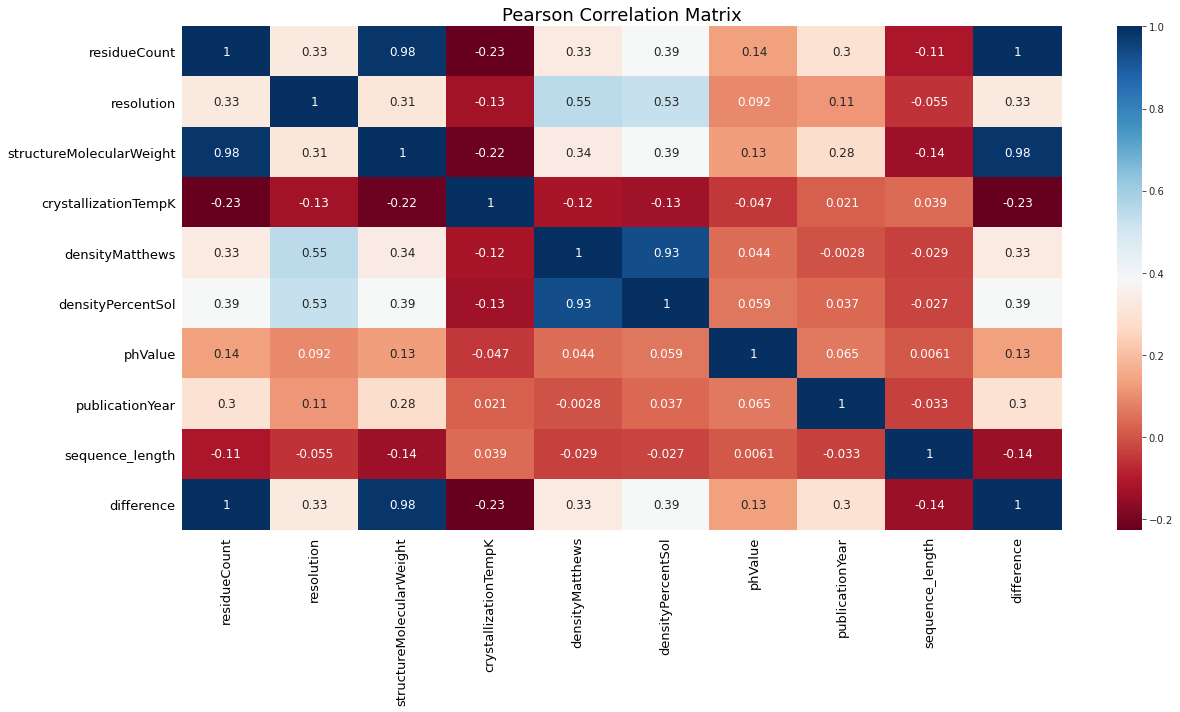

In [ ]:
corr_matrix(df_protein[numeric_cols])

* Monika padek man jau iskepe smegenys

### Columns with Meaningless(hard to work with) or Redundant Data

However, I would love to get some meaning from these columns.

In [ ]:
columns_to_drop = ['pdbxDetails', 'sequence']

df_protein = df_protein.drop(columns=columns_to_drop)
df_protein = df_protein.reset_index(drop=True)

In [ ]:
df_protein

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,phValue,publicationYear,chainId,sequence_length,difference,phLabel
0,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572.0,2.15,65203.21,NaN,NaN,2.71,54.69,6.0,1998.0,A,286,286.0,Acid
1,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572.0,2.15,65203.21,NaN,NaN,2.71,54.69,6.0,1998.0,B,286,286.0,Acid
2,11BA,HYDROLASE,X-RAY DIFFRACTION,Protein,248.0,2.06,28700.28,NaN,NaN,2.48,50.36,4.8,1998.0,A,124,124.0,Acid
3,11BA,HYDROLASE,X-RAY DIFFRACTION,Protein,248.0,2.06,28700.28,NaN,NaN,2.48,50.36,4.8,1998.0,B,124,124.0,Acid
4,11BG,HYDROLASE,X-RAY DIFFRACTION,Protein,248.0,1.90,30391.41,NaN,NaN,2.40,48.68,4.8,1999.0,A,124,124.0,Acid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158671,9GSS,TRANSFERASE,X-RAY DIFFRACTION,Protein,418.0,1.97,47764.66,NaN,NaN,2.56,51.96,6.0,1997.0,A,209,209.0,Acid
158672,9GSS,TRANSFERASE,X-RAY DIFFRACTION,Protein,418.0,1.97,47764.66,NaN,NaN,2.56,51.96,6.0,1997.0,B,209,209.0,Acid
158673,9JDW,TRANSFERASE,X-RAY DIFFRACTION,Protein,386.0,2.50,44444.61,NaN,NaN,3.83,68.00,7.0,1999.0,A,386,0.0,Neutral
158674,9NSE,OXIDOREDUCTASE,X-RAY DIFFRACTION,Protein,888.0,2.24,102350.65,NaN,NaN,2.41,50.00,6.5,2000.0,A,444,444.0,Acid


### Visualizing the tweaked Dataset Classification Types

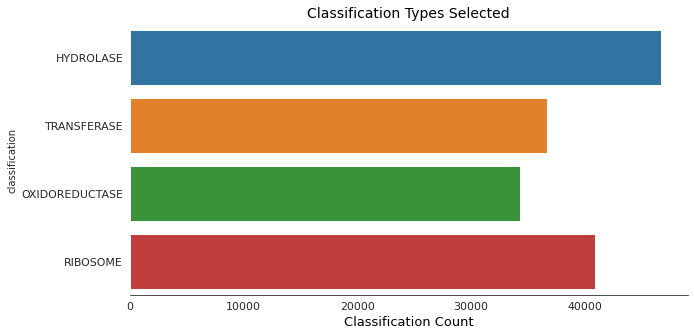

In [ ]:
# Classification Type that will be used from now on
plt.figure(figsize=(10,5))
plt.subplot(1,1,1)
bar_plot_cas('classification', df_protein, 'Classification Count', 'Classification Types Selected')

**Perhaps undersampling the top classifications in order to balance the dataset.
Hydrolase and Ribosome has 10 000 more data samples which would make the dataset biased. To tackle this I will balance the dataset by undersampling Hydrolase and Ribosome categories.**
* Not sure whether I should really do this before splitting the dataset.

### Balancing the Dataset

In [ ]:
df_protein.classification.value_counts()

HYDROLASE         46732
RIBOSOME          40946
TRANSFERASE       36667
OXIDOREDUCTASE    34331
Name: classification, dtype: int64

In [ ]:
count_class_0, count_class_1, count_class_2, count_class_3 = df_protein.classification.value_counts()

# Divide by class
df_class_0 = df_protein[df_protein['classification'] == 'RIBOSOME']
df_class_1 = df_protein[df_protein['classification'] == 'HYDROLASE']
df_class_2 = df_protein[df_protein['classification'] == 'TRANSFERASE']
df_class_3 = df_protein[df_protein['classification'] == 'OXIDOREDUCTASE']

Random under-sampling:
HYDROLASE         36667
RIBOSOME          36667
TRANSFERASE       36667
OXIDOREDUCTASE    34331
Name: classification, dtype: int64


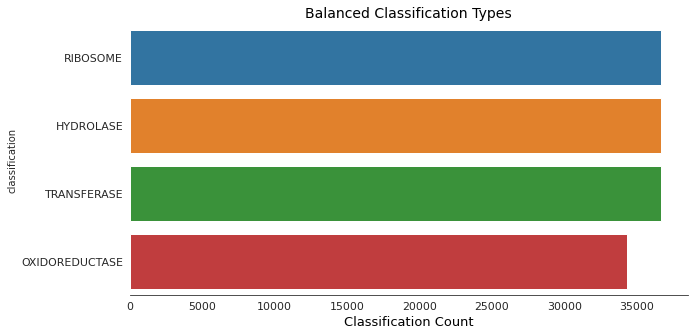

In [ ]:
df_class_0_under = df_class_0.sample(count_class_2)
df_class_1_under = df_class_1.sample(count_class_2)
df_protein_under = pd.concat([df_class_0_under, df_class_1_under, df_class_2, df_class_3], axis=0)

print('Random under-sampling:')
print(df_protein_under.classification.value_counts())
plt.figure(figsize=(10,5))
plt.subplot(1,1,1)
bar_plot_cas('classification', df_protein_under, 'Classification Count', 'Balanced Classification Types')

### Defining the most represented Classifications:

**Hydrolase** is a class of enzyme that commonly perform as biochemical catalysts that use water to break a chemical bond, which typically results in dividing a larger molecule to smaller molecules. Some common examples of hydrolase enzymes are esterases including lipases, phosphatases, glycosidases, peptidases, and nucleosidases.

**Transferase** is any one of a class of enzymes that enact the transfer of specific functional groups other than hydrogen (e.g. a methyl or glycosyl group) from one molecule (called the donor) to another (called the acceptor). They are involved in hundreds of different biochemical pathways throughout biology, and are integral to some of life's most important processes.

**Oxidoreductase** is an enzyme that catalyzes the transfer of electrons from one molecule, the reductant, also called the electron donor, to another, the oxidant, also called the electron acceptor. This group of enzymes usually utilizes NADP or NAD+ as cofactors. Transmembrane oxidoreductases create electron transport chains in bacteria, chloroplasts and mitochondria, including respiratory complexes I, II and III. Some others can associate with biological membranes as peripheral membrane proteins or be anchored to the membranes through a single transmembrane helix.

**Ribosomes** comprise a complex macromolecular machine, found within all living cells, that serves as the site of biological protein synthesis (translation). Ribosomes link amino acids together in the order specified by messenger RNA (mRNA) molecules. Ribosomes consist of two major components: the small ribosomal subunits, which read the mRNA, and the large subunits, which join amino acids to form a polypeptide chain. Each subunit consists of one or more ribosomal RNA (rRNA) molecules and a variety of ribosomal proteins. The ribosomes and associated molecules are also known as the translational apparatus.

### Plotting the missing Data

In [ ]:
df_protein_under = df_protein_under.reset_index(drop=True)

In [ ]:
plot_miss(df_protein_under)

,Columns,% of Missing Data
0,crystallizationMethod,31.6
1,crystallizationTempK,31.1
2,phValue,24.9
3,publicationYear,14.1
4,densityMatthews,12.7
5,densityPercentSol,12.7
6,resolution,0.8
7,chainId,0.0
8,residueCount,0.0
9,classification,0.0


### Formating Structure ID

In [ ]:
df_protein_under

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,phValue,publicationYear,chainId,sequence_length,difference,phLabel
0,4U1U,RIBOSOME,X-RAY DIFFRACTION,Protein#RNA,20810.0,2.95,4269911.50,EVAPORATION,291.0,3.40,63.70,6.5,2014.0,CF,100,20710.0,Acid
1,4V6D,RIBOSOME,X-RAY DIFFRACTION,Protein#RNA,21120.0,3.81,4308870.00,MICROBATCH,291.0,3.35,63.30,7.0,2009.0,AI,130,20990.0,Neutral
2,5LZT,RIBOSOME,ELECTRON MICROSCOPY,Protein#RNA,20340.0,3.65,3544784.75,NaN,NaN,NaN,NaN,NaN,2016.0,G,319,20021.0,Neutral
3,4U4O,RIBOSOME,X-RAY DIFFRACTION,Protein#RNA,35344.0,3.60,6630740.50,"VAPOR DIFFUSION, HANGING DROP",277.0,3.07,59.96,7.5,2014.0,8,158,35186.0,Base
4,5E7K,RIBOSOME,X-RAY DIFFRACTION,Protein#RNA,21966.0,3.20,4551911.00,"VAPOR DIFFUSION, SITTING DROP",293.0,3.24,62.03,NaN,2016.0,H8,206,21760.0,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144327,8LDH,OXIDOREDUCTASE,X-RAY DIFFRACTION,Protein,330.0,2.80,36737.55,NaN,NaN,2.88,57.26,NaN,1987.0,A,330,0.0,Neutral
144328,8NSE,OXIDOREDUCTASE,X-RAY DIFFRACTION,Protein,888.0,2.25,102099.66,NaN,NaN,2.43,50.00,6.5,2001.0,A,444,444.0,Acid
144329,8NSE,OXIDOREDUCTASE,X-RAY DIFFRACTION,Protein,888.0,2.25,102099.66,NaN,NaN,2.43,50.00,6.5,2001.0,B,444,444.0,Acid
144330,9NSE,OXIDOREDUCTASE,X-RAY DIFFRACTION,Protein,888.0,2.24,102350.65,NaN,NaN,2.41,50.00,6.5,2000.0,A,444,444.0,Acid


In [ ]:
id_map = {}
index = 0
for i in range(df_protein_under.structureId.index[-1]):
  if i==0:
    id_map.update({df_protein_under.structureId[i]:index})
  if id_map.get(df_protein_under.structureId[i]) == None:
    index+=1
    id_map.update({df_protein_under.structureId[i]:index})
#df_protein_under.structureId = df_protein_under.structureId.astype('category')
#df_protein_under.structureId = df_protein_under.structureId.cat.codes


In [ ]:
struct_id = df_protein_under.structureId
struct_id = struct_id.map(id_map)

In [ ]:
df_protein_under = df_protein_under.assign(structureId=struct_id)

## Machine Learning & additional Statistical Analysis

### Preparations

In [ ]:
df_protein_under.describe(include='all')

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,phValue,publicationYear,chainId,sequence_length,difference,phLabel
count,144332.000000,144332,144332,144332,144332.000000,143207.000000,1.443320e+05,98699,99430.000000,125932.000000,125982.000000,108326.000000,123978.000000,144325,144332.000000,144332.000000,144332
unique,NaN,4,3,3,NaN,NaN,NaN,250,NaN,NaN,NaN,NaN,NaN,1540,NaN,NaN,3
top,NaN,HYDROLASE,X-RAY DIFFRACTION,Protein,NaN,NaN,NaN,"VAPOR DIFFUSION, HANGING DROP",NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,Neutral
freq,NaN,36667,127306,107117,NaN,NaN,NaN,50717,NaN,NaN,NaN,NaN,NaN,43184,NaN,NaN,51623
mean,18277.230787,NaN,NaN,NaN,6406.573774,2.870084,1.116881e+06,NaN,290.293066,2.825373,54.135236,6.833555,2010.890908,NaN,295.154366,6111.419408,NaN
std,16082.109249,NaN,NaN,NaN,9696.791558,2.053575,1.828058e+06,NaN,8.754811,0.692602,9.628194,1.121020,5.208911,NaN,275.044193,9731.875643,NaN
min,0.000000,NaN,NaN,NaN,13.000000,0.640000,1.430710e+03,NaN,4.000000,0.970000,0.280000,0.000000,1974.000000,NaN,2.000000,-1.000000,NaN
25%,617.000000,NaN,NaN,NaN,640.000000,1.980000,7.250321e+04,NaN,289.000000,2.320000,47.000000,6.200000,2007.000000,NaN,145.000000,333.000000,NaN
50%,17426.500000,NaN,NaN,NaN,1532.000000,2.410000,1.718869e+05,NaN,293.000000,2.670000,53.870000,7.000000,2012.000000,NaN,252.000000,1184.000000,NaN
75%,33306.000000,NaN,NaN,NaN,7482.000000,3.100000,1.185279e+06,NaN,295.000000,3.180000,61.230000,7.500000,2015.000000,NaN,365.000000,7277.000000,NaN


In [ ]:
numeric_cols, categ_cols = find_dtype_col(df_protein_under)
categ_cols.remove('classification')
target_col = ['classification']

In [ ]:
imp=SimpleImputer()
df_protein=pd.DataFrame(imp.fit_transform(df_protein_under[numeric_cols]))
df_protein.columns=numeric_cols
df_protein.index=df_protein_under.index

In [ ]:
df_protein_imputed = pd.concat([df_protein, df_protein_under[categ_cols+target_col]], axis=1)

In [ ]:
convert_dict = {'residueCount':int,
                'structureId':int,
                'publicationYear':int,
                'sequence_length':int,
                'difference':int
               } 
  
df_protein_imputed = df_protein_imputed.astype(convert_dict) 

In [ ]:
X = df_protein_imputed.drop(columns=target_col)
y = df_protein_imputed.classification

In [ ]:
classifications = {'RIBOSOME':0, 'HYDROLASE':1, 'TRANSFERASE':2, 'OXIDOREDUCTASE':3}
y = y.map(classifications)

### Statistical Analysis and Data Transformation

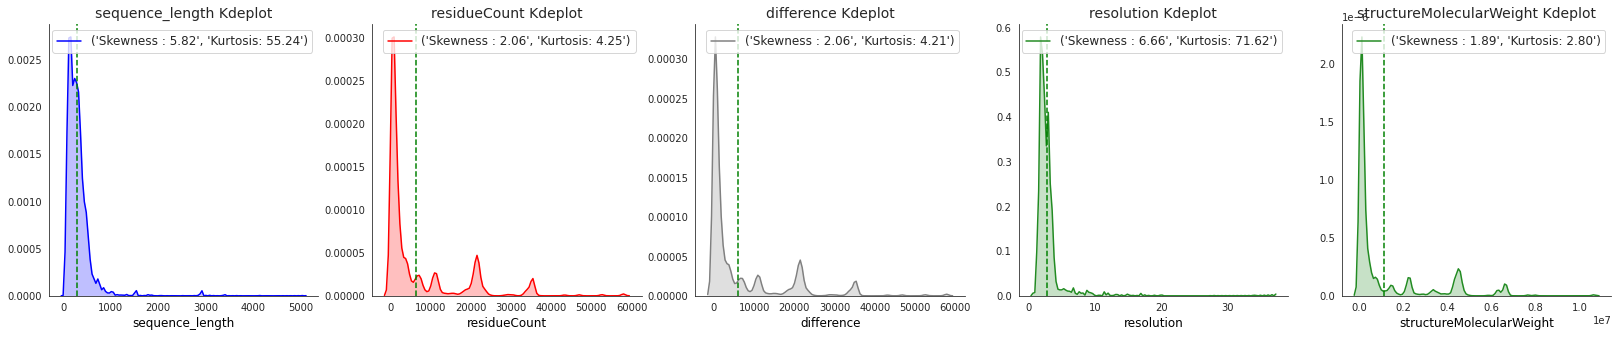

In [ ]:
stat_kde_plot(df_protein_imputed, 'sequence_length','residueCount', 'difference', 'resolution', 'structureMolecularWeight')

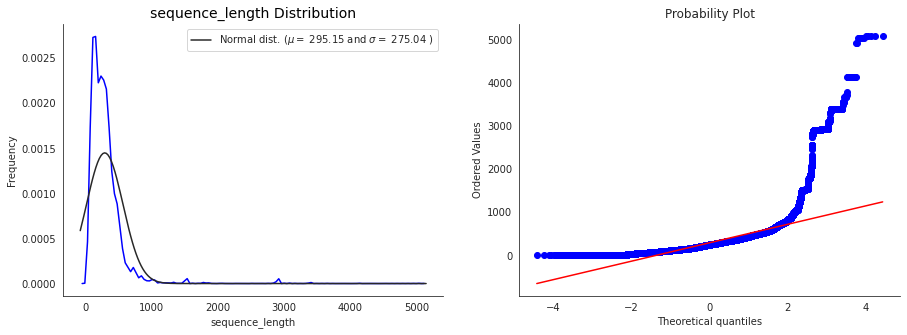

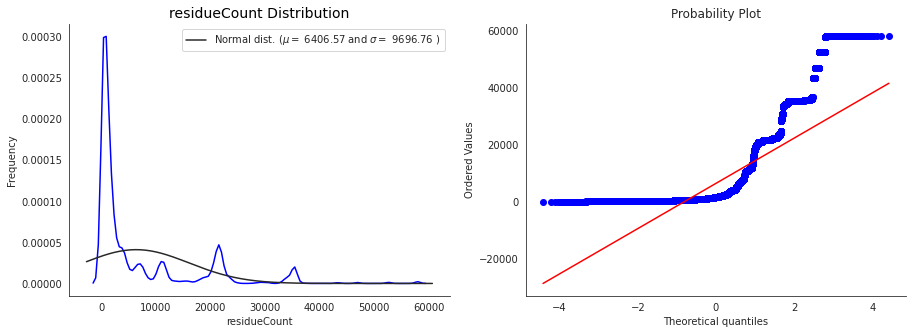

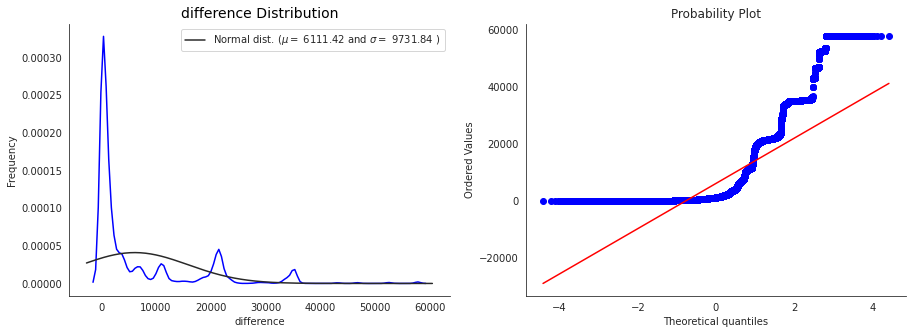

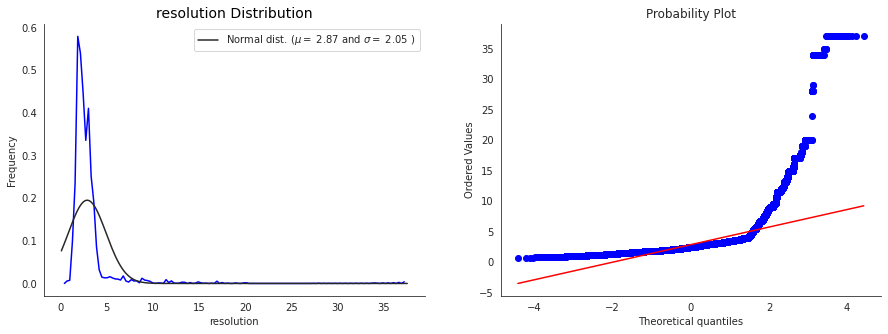

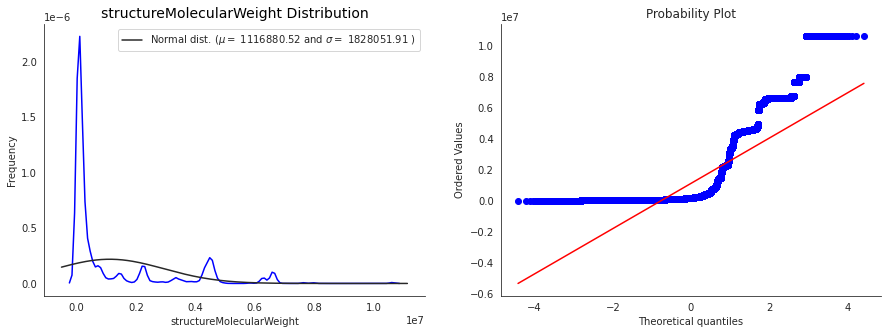

In [ ]:
stat_plot(df_protein_imputed, 'sequence_length')
stat_plot(df_protein_imputed, 'residueCount')
stat_plot(df_protein_imputed, 'difference')
stat_plot(df_protein_imputed, 'resolution')
stat_plot(df_protein_imputed, 'structureMolecularWeight')

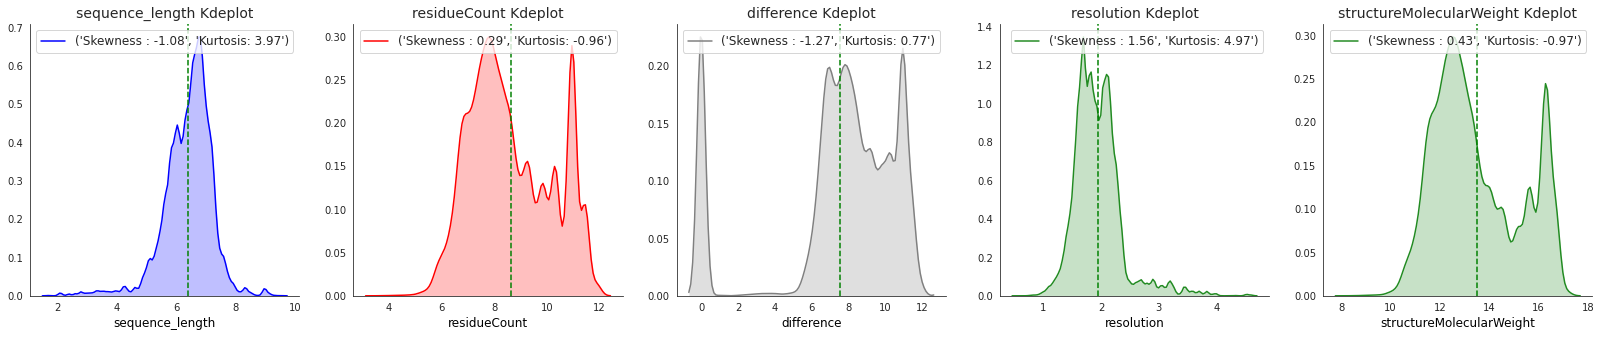

In [ ]:
for i in ['sequence_length','residueCount', 'difference', 'resolution', 'structureMolecularWeight']:
    df_protein_imputed[i] = df_protein_imputed[i].map(lambda i: np.log(i)+1 if i > 0 else 0)
stat_kde_plot(df_protein_imputed, 'sequence_length','residueCount', 'difference', 'resolution', 'structureMolecularWeight')

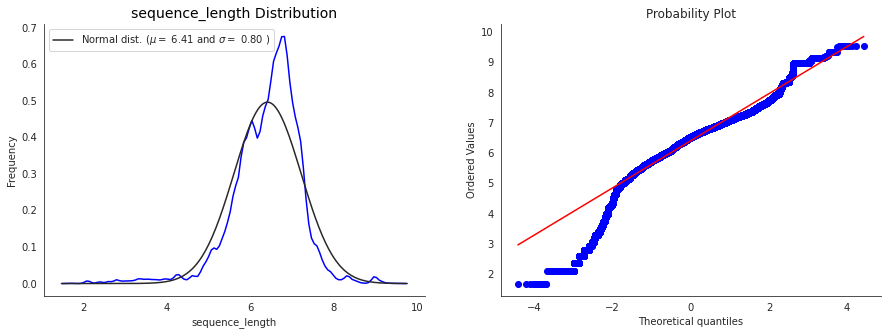

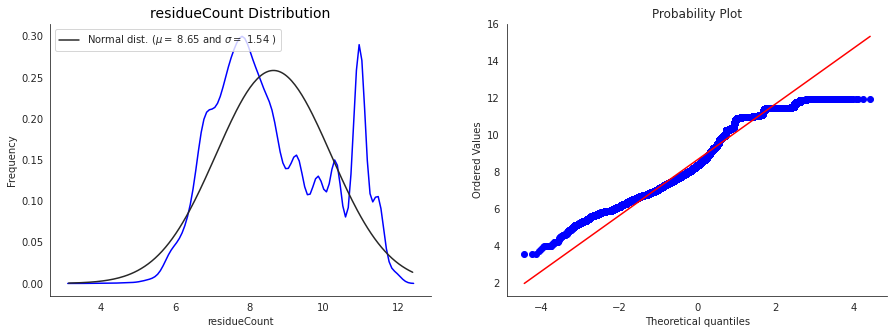

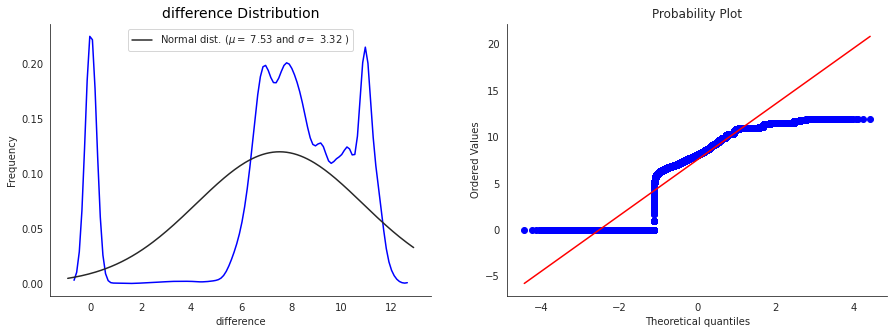

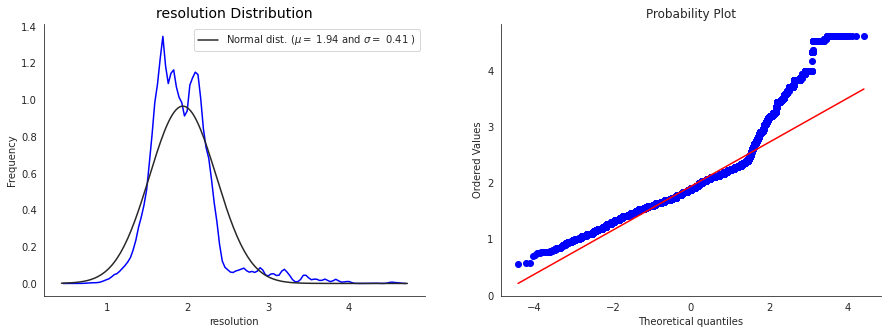

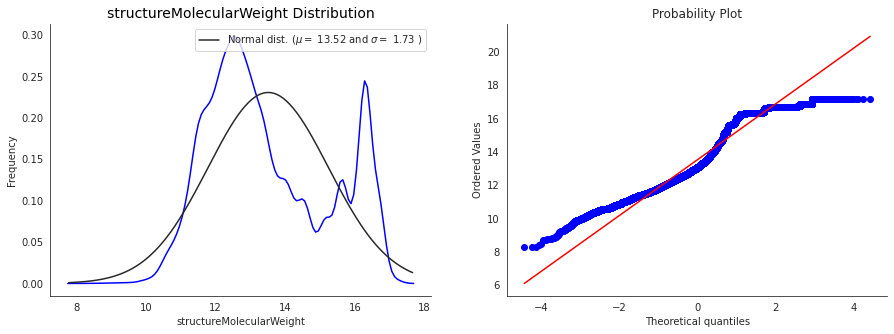

In [ ]:
stat_plot(df_protein_imputed, 'sequence_length')
stat_plot(df_protein_imputed, 'residueCount')
stat_plot(df_protein_imputed, 'difference')
stat_plot(df_protein_imputed, 'resolution')
stat_plot(df_protein_imputed, 'structureMolecularWeight')

**Gal but skelti i kelias grupes, pvz difference skelti dar ir i 0 su true false values feature engineering, ismesti kazkuri column**

### Pipeline, Fitting the First Model

Sugalvoti kazka su imputinimu

In [ ]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='mean')),
('std_scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    #('ordinal_encoder', OrdinalEncoder()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('cat', categorical_transformer, categ_cols)
    ])

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
protein_prepared_train = my_pipeline.fit_transform(X_train, y_train)
protein_prepared_valid = my_pipeline.transform(X_val)

In [ ]:
model = RandomForestClassifier(n_jobs=-1, random_state=1)
model.fit(protein_prepared_train,y_train)
y_pred_val = model.predict(protein_prepared_valid)
accuracy_score(y_val, y_pred_val) 

0.99940878690463

### Model Insights

In [ ]:
rf_base_conf = confusion_matrix(y_pred_val,y_val)
rf_base_conf

array([[6832,    0,    0,    0],
       [  13, 6901,    0,    0],
       [   0,    1, 6883,    1],
       [   0,    0,    1, 6431]])

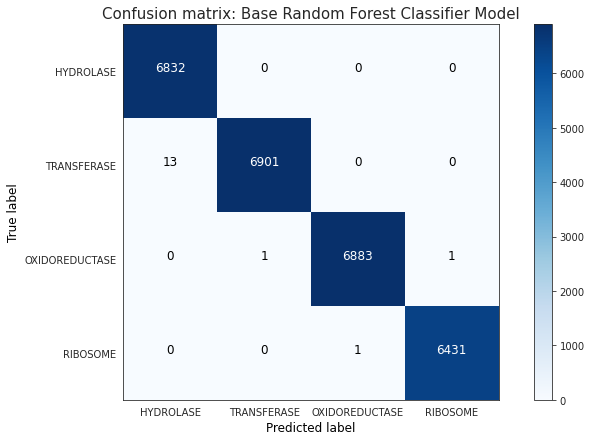

In [ ]:
classes = ['HYDROLASE', 'TRANSFERASE', 'OXIDOREDUCTASE', 'RIBOSOME']
plot_confusion_matrix(rf_base_conf, classes,'Base Random Forest Classifier Model')

In [ ]:
dummy_train = pd.get_dummies(X_train)
dummy_train = dummy_train.reset_index(drop=True)

In [ ]:
dummy_train

,structureId,residueCount,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue,publicationYear,sequence_length,difference,phLabel_Acid,phLabel_Base,phLabel_Neutral,macromoleculeType_Protein,macromoleculeType_Protein#DNA,macromoleculeType_Protein#RNA,experimentalTechnique_ELECTRON MICROSCOPY,experimentalTechnique_SOLUTION NMR,experimentalTechnique_X-RAY DIFFRACTION,chainId_0,chainId_01,chainId_02,chainId_03,chainId_04,chainId_05,chainId_06,chainId_07,chainId_08,chainId_09,chainId_0B,chainId_0D,chainId_0X,chainId_1,chainId_10,chainId_11,chainId_12,chainId_13,chainId_14,chainId_15,...,crystallizationMethod_oil micro batch,crystallizationMethod_oil microbatch,crystallizationMethod_oil-batch,crystallizationMethod_oil-micro batch,crystallizationMethod_seeding,crystallizationMethod_seeding-capillary counter diffusion,crystallizationMethod_sitting batch,crystallizationMethod_sitting drop,crystallizationMethod_sitting drop vapor diffuction,crystallizationMethod_sitting drop vapor diffusion,crystallizationMethod_sitting drop vapor diffusion using polymer-induced heteronucleation,"crystallizationMethod_sitting drop, vapor diffusion",crystallizationMethod_sitting-drop vapor diffusion,crystallizationMethod_small-scale batch method,crystallizationMethod_soaking,crystallizationMethod_soaking the Rev3-Rev7-Rev1 crystals with the RIR peptide of Polkappa,crystallizationMethod_streak seeding,crystallizationMethod_under oil,"crystallizationMethod_vapor batch, under oil",crystallizationMethod_vapor diffusion - hanging drop - microseeding,crystallizationMethod_vapor diffusion - hanging drop - streak seeding,crystallizationMethod_vapor diffusion - hanging drop in anaerobic atmosphere,crystallizationMethod_vapor diffusion - sitting drop - macroseeding,crystallizationMethod_vapor diffusion method,crystallizationMethod_vapor diffusion under oil,crystallizationMethod_vapor diffusion with microseeding,"crystallizationMethod_vapor diffusion, hanging drop with micro-seeding","crystallizationMethod_vapor diffusion, hanging drop, cocrystallization","crystallizationMethod_vapor diffusion, hanging drop, microseeding","crystallizationMethod_vapor diffusion, hanging drop, seeding","crystallizationMethod_vapor diffusion, macro-seeding, Soaking","crystallizationMethod_vapor diffusion, under oil","crystallizationMethod_vapor diffusion,hanging drop and microseeding","crystallizationMethod_vapordiffusion, combined with soaking with inhibitor at 1 mM concentration",crystallizationMethod_vapour diffusion + soaking,crystallizationMethod_vapour diffusion cocrystals,"crystallizationMethod_vapour diffusion sitting-drop, micro-seeding","crystallizationMethod_vapour diffusion, hanging drop","crystallizationMethod_vapour diffusion, sitting drop",crystallizationMethod_vapr diffusion
0,29228,1712,1.50,197970.09,298.000000,2.18,43.60,7.5,2010,214,1498,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4548,1048,2.63,119818.60,294.000000,4.89,74.85,6.5,2010,262,786,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10179,198,1.75,22317.18,290.293066,2.71,54.68,5.0,2008,99,99,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9777,616,1.75,71895.63,277.000000,2.48,50.48,7.5,2010,308,308,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,22515,2096,2.50,237883.73,292.000000,2.73,54.98,4.6,2006,262,1834,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

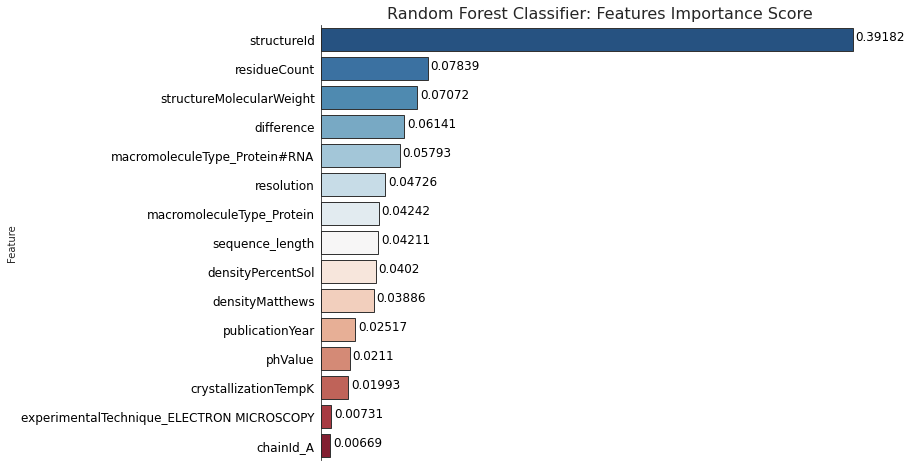

In [ ]:
sing_model(model, 'Random Forest Classifier')

### Dropping StructureID

In [ ]:
numeric_cols, categ_cols = find_dtype_col(df_protein_under)
categ_cols.remove('classification')
target_col = ['classification']
print('Numeric columns: ', numeric_cols)
print('Categorical columns: ', categ_cols)
print('Target columns: ', target_col)

Numeric columns:  ['structureId', 'residueCount', 'resolution', 'structureMolecularWeight', 'crystallizationTempK', 'densityMatthews', 'densityPercentSol', 'phValue', 'publicationYear', 'sequence_length', 'difference']
Categorical columns:  ['phLabel', 'macromoleculeType', 'experimentalTechnique', 'chainId', 'crystallizationMethod']
Target columns:  ['classification']


In [ ]:
numeric_cols.remove('structureId')
X = X.drop(columns='structureId')

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('cat', categorical_transformer, categ_cols)
    ])

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
dummy_train = pd.get_dummies(X_train)
dummy_train = dummy_train.reset_index(drop=True)

In [ ]:
protein_prepared_train = my_pipeline.fit_transform(X_train, y_train)
X_train_test = my_pipeline.transform(X_train)
protein_prepared_valid = my_pipeline.transform(X_val)

In [ ]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(protein_prepared_train,y_train)
y_pred_train = model.predict(X_train_test)
y_pred_val = model.predict(protein_prepared_valid)

accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_val)

(0.9999876826053753, 0.8479843328529727)

**regulalisation as this might indicate that my model is overfitting** 

### Base Random Forest Insights

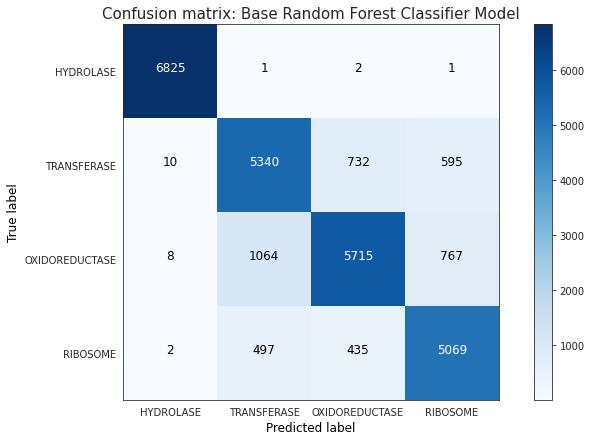

In [ ]:
rf_base_conf = confusion_matrix(y_pred_val,y_val)
plot_confusion_matrix(rf_base_conf, classes,'Base Random Forest Classifier Model')

In [ ]:
tree_model = DecisionTreeClassifier(max_depth=5, min_samples_split=5).fit(protein_prepared_train, y_train)
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=dummy_train.columns)
graphviz.Source(tree_graph)

In [ ]:
sing_model(model, 'Random Forest Classifier')

### Fitting a variety of models

In [ ]:
model_type = [KNeighborsClassifier(n_jobs=-1), GaussianNB(), XGBClassifier(n_jobs=-1), RandomForestClassifier(n_jobs=-1),
              ExtraTreesClassifier(n_jobs=-1), SGDClassifier(n_jobs=-1)]
 
model_scores = [model_score(i, protein_prepared_train.todense(), y_train, protein_prepared_valid.todense(), y_val) for i in model_type]

In [ ]:
lr_score = model_score(LogisticRegression(n_jobs=-1), protein_prepared_train.todense(), y_train, protein_prepared_valid.todense(), y_val)

In [ ]:
model_scores.append(lr_score)

In [ ]:
print(model_scores)

In [ ]:
classifier = ['KNeighbors','Naive Bayes','XGBoost', 'Random Forest', 'Extra Trees', 'Linear Support Vector Machine', 'Logistic Regression']

plot_model_scores(model_scores, classifier)

### Hyper Parameter Tuning

* **DNA** or deoxyribonucleic acid is the molecule that encodes genetic information necessary for all cellular functions. DNA is composed of the sugar deoxyribose, phosphate groups, and the bases adenine , thymine (T), guanine (G) and cytosine (C). The DNA molecule is normally a double helix in which the two strands are bound through complementarity of the bases. Cs from one strand hydrogen bind to Gs of the other strand and vice versa. Similarly, As and Ts hydrogen bind to each other.

* **Ribonucleic acid (RNA)** is a polymeric molecule essential in various biological roles in coding, decoding, regulation and expression of genes. RNA and DNA are nucleic acids, and, along with lipids, proteins and carbohydrates, constitute the four major macromolecules essential for all known forms of life. Like DNA, RNA is assembled as a chain of nucleotides, but unlike DNA, RNA is found in nature as a single strand folded onto itself, rather than a paired double strand. Cellular organisms use messenger RNA (mRNA) to convey genetic information (using the nitrogenous bases of guanine, uracil, adenine, and cytosine, denoted by the letters G, U, A, and C) that directs synthesis of specific proteins. Many viruses encode their genetic information using an RNA genome.

  Some RNA molecules play an active role within cells by catalyzing biological reactions, controlling gene expression, or sensing and communicating responses to cellular signals. One of these active processes is protein synthesis, a universal function in which RNA molecules direct the synthesis of proteins on ribosomes. This process uses transfer RNA (tRNA) molecules to deliver amino acids to the ribosome, where ribosomal RNA (rRNA) then links amino acids together to form coded proteins.

* **Messenger RNA (mRNA)** is a single-stranded RNA molecule that corresponds to the genetic sequence of a gene and is read by the ribosome in the process of producing a protein. mRNA is created during the process of transcription, where the enzyme RNA polymerase converts genes into primary transcript mRNA (also known as pre-mRNA). This pre-mRNA usually still contains introns, regions that will not go on to code for the final amino acid sequence. These are removed in the process of RNA splicing, leaving only exons, regions that will encode the protein. This exon sequence constitutes mature mRNA. Mature mRNA is then read by the ribosome, and, utilising amino acids carried by transfer RNA (tRNA), the ribosome creates the protein. This process is known as translation. 

* **RNA splicing**, in molecular biology, is a form of RNA processing in which a newly made precursor messenger RNA (pre-mRNA) transcript is transformed into a mature messenger RNA (mRNA). During splicing, introns (Non-coding regions) are removed and exons (Coding Regions) are joined together. For nuclear-encoded genes, splicing takes place within the nucleus either during or immediately after transcription. For those eukaryotic genes that contain introns, splicing is usually required in order to create an mRNA molecule that can be translated into protein. For many eukaryotic introns, splicing is carried out in a series of reactions which are catalyzed by the spliceosome, a complex of small nuclear ribonucleo proteins (snRNPs). Self-splicing introns, or ribozymes capable of catalyzing their own excision from their parent RNA molecule, also exist.

* **Protein synthesis** is the biological process by which cells generate proteins from RNA. Translation, the assembly of amino acids by ribosomes, is an essential part of the biosynthetic pathway, along with generation of messenger RNA (mRNA), aminoacylation of transfer RNA (tRNA), co-translational transport, and post-translational modification.

* **Ribosomal ribonucleic acid (rRNA)** is a noncoding type of RNA that acts as the primary building block for ribosomes and the assembly line on which protein synthesis occurs in those ribosomes, essential to all living organisms. Ribosomal RNA is transcribed from ribosomal DNA (rDNA) and then bound to ribosomal proteins to form the specific subunits of ribosomes. More crucially, however, rRNA acts as the physical and mechanical actor that forces mRNA and tRNA through the ribosome to process and translate both into functioning proteins. Ribosomal RNA is the predominant form of RNA found in most cells, as it composes around 80% of cellular RNA despite never being translated into proteins itself. Ribosomes are composed of approximately 60% rRNA and 40% other ribosomal proteins by mass.

* **Ribosomes** comprise a complex macromolecular machine, found within all living cells, that serves as the site of biological protein synthesis (translation). Ribosomes link amino acids together in the order specified by messenger RNA (mRNA) molecules. Ribosomes consist of two major components: the small ribosomal subunits, which read the mRNA, and the large subunits, which join amino acids to form a polypeptide chain. Each subunit consists of one or more ribosomal RNA (rRNA) molecules and a variety of ribosomal proteins (r-protein or rProtein). The ribosomes and associated molecules are also known as the translational apparatus.

* **Translation** is the process in which ribosomes in the cytoplasm or ER synthesize proteins after the process of transcription of DNA to RNA in the cell's nucleus. The entire process is called gene expression.

  In translation, messenger RNA (mRNA) is decoded in the ribosome decoding center to produce a specific amino acid chain, or polypeptide. The polypeptide later folds into an active protein and performs its functions in the cell. The ribosome facilitates decoding by inducing the binding of complementary tRNA anticodon sequences to mRNA codons. The tRNAs carry specific amino acids that are chained together into a polypeptide as the mRNA passes through and is read by the ribosome.

  Translation proceeds in three phases:

1. Initiation: The ribosome assembles around the target mRNA. The first tRNA is attached at the start codon.

2. Elongation: The tRNA transfers an amino acid to the tRNA corresponding to the next codon. The ribosome then moves (translocates) to the next mRNA codon to continue the process, creating an amino acid chain.
3. Termination: When a peptidyl tRNA encounters a stop codon, then the ribosome folds the polypeptide into its final structure.

* **Proteins** are large biomolecules, or macromolecules, consisting of one or more long chains of amino acid residues. Proteins perform a vast array of functions within organisms, including catalysing metabolic reactions, DNA replication, responding to stimuli, providing structure to cells, and organisms, and transporting molecules from one location to another. Proteins differ from one another primarily in their sequence of amino acids, which is dictated by the nucleotide sequence of their genes, and which usually results in protein folding into a specific three-dimensional structure that determines its activity.

* **Protein crystallization** is the process of formation of a protein crystal. Protein crystals are useful in the study of protein structures for use in medicine, amongst other applications. In the process of protein crystallization, proteins are dissolved in an aqueous environment and sample solution until they reach the supersaturated state.This supersaturated state allows researchers to study the internal structure of proteins. Different methods are used to reach that state such as vapor diffusion, microbatch, microdialysis, and free-interface diffusion. Developing protein crystals is difficult, as the process is influenced by many factors, including pH, temperature, ionic strength in the crystallization solution, and even gravity.
Based on the crystals, the determination of protein structure can traditionally be achieved by utilizing X-Ray Diffraction (XRD). Alternatively, cryo-electron microscopy (cryo-EM) and nuclear magnetic resonance (NMR) could also be used for protein structure determination.
<br/>
* **Enzyme**
A macromolecule that is capable of catalyzing, or speeding up, specific biochemical reactions without being permanently altered or consumed. The term enzyme usually refers to proteins, but some RNA molecules can also function as enzymes.
* **Transferase** is any one of a class of enzymes that enact the transfer of specific functional groups (e.g. a methyl or glycosyl group) from one molecule (called the donor) to another (called the acceptor). They are involved in hundreds of different biochemical pathways throughout biology, and are integral to some of life's most important processes.

* **Oxidoreductase** is an enzyme that catalyzes the transfer of electrons from one molecule, the reductant, also called the electron donor, to another, the oxidant, also called the electron acceptor. This group of enzymes usually utilizes NADP or NAD+ as cofactors. Transmembrane oxidoreductases create electron transport chains in bacteria, chloroplasts and mitochondria, including respiratory complexes I, II and III. Some others can associate with biological membranes as peripheral membrane proteins or be anchored to the membranes through a single transmembrane helix.
* **Hydrolase** is a class of enzyme that commonly perform as biochemical catalysts that use water to break a chemical bond, which typically results in dividing a larger molecule to smaller molecules. Some common examples of hydrolase enzymes are esterases including lipases, phosphatases, glycosidases, peptidases, and nucleosidases.
* **Genetically modified bacteria** were the first organisms to be modified in the laboratory, due to their simple genetics.These organisms are now used for several purposes, and are particularly important in producing large amounts of pure human proteins for use in medicine.
* **Escherichia coli** also known as E. coli is a Gram-negative, facultative anaerobic, rod-shaped, coliform bacterium of the genus Escherichia that is commonly found in the lower intestine of warm-blooded organisms (endotherms).[4]Most E. coli strains are harmless, but some serotypes can cause serious food poisoning in their hosts, and are occasionally responsible for product recalls due to food contamination. The harmless strains are part of the normal microbiota of the gut, and can benefit their hosts by producing vitamin K2,[8] (which helps blood to clot) and preventing colonisation of the intestine with pathogenic bacteria, having a symbiotic relationship. E. coli is expelled into the environment within fecal matter. The bacterium grows massively in fresh fecal matter under aerobic conditions for 3 days, but its numbers decline slowly afterwards.
* **Convolution** is a mathematical operation on two functions (f and g) that produces a third function expressing how the shape of one is modified by the other. The term convolution refers to both the result function and to the process of computing it. It is defined as the integral of the product of the two functions after one is reversed and shifted.
* **Deconvolution** is an algorithm-based process used to reverse the effects of convolution on recorded data. The concept of deconvolution is widely used in the techniques of signal processing and image processing. Because these techniques are in turn widely used in many scientific and engineering disciplines, deconvolution finds many applications. In general, the objective of deconvolution is to find the solution of a convolution equation of the form:
f * g = h, 
Usually, h is some recorded signal, and f is some signal that we wish to recover, but has been convolved with some other signal g before we recorded it.
* **Asymmetric unit**
The smallest part of a crystal structure to which space group symmetry can be applied to produce the entire crystal. The asymmetric unit may contain a whole molecule, a portion of a molecule, or multiple molecules and does not necessarily represent the functional unit of the molecule under investigation.
* **resolution**

  Resolution is a measure of the quality of the data that has been collected on the crystal containing the protein or nucleic acid. If all of the proteins in the crystal are aligned in an identical way, forming a very perfect crystal, then all of the proteins will scatter X-rays the same way, and the diffraction pattern will show the fine details of crystal. On the other hand, if the proteins in the crystal are all slightly different, due to local flexibility or motion, the diffraction pattern will not contain as much fine information. So resolution is a measure of the level of detail present in the diffraction pattern and the level of detail that will be seen when the electron density map is calculated. High-resolution structures, with resolution values of 1 Å or so, are highly ordered and it is easy to see every atom in the electron density map. Lower resolution structures, with resolution of 3 Å or higher, show only the basic contours of the protein chain, and the atomic structure must be inferred. Most crystallographic-defined structures of proteins fall in between these two extremes. As a general rule of thumb, we have more confidence in the location of atoms in structures with resolution values that are small, called "high-resolution structures".

* **A polymer** is a large molecule, or macromolecule, composed of many repeated subunits. Due to their broad range of properties, both synthetic and natural polymers play essential and ubiquitous roles in everyday life. Polymers range from familiar synthetic plastics such as polystyrene to natural biopolymers such as DNA and proteins that are fundamental to biological structure and function. Polymers, both natural and synthetic, are created via polymerization of many small molecules, known as monomers. Their consequently large molecular mass, relative to small molecule compounds, produces unique physical properties including toughness, viscoelasticity, and a tendency to form glasses and semicrystalline structures rather than crystals.

* **RNA polymerase**, is an enzyme that synthesizes RNA from a DNA template. RNAP locally opens the double-stranded DNA (usually about four turns of the double helix) so that one strand of the exposed nucleotides can be used as a template for the synthesis of RNA, a process called transcription. A transcription factor and its associated transcription mediator complex must be attached to a DNA binding site called a promoter region before RNAP can initiate the DNA unwinding at that position. RNAP not only initiates RNA transcription, it also guides the nucleotides into position, facilitates attachment and elongation, has intrinsic proofreading and replacement capabilities, and termination recognition capability. In eukaryotes, RNAP can build chains as long as 2.4 million nucleotides.

Sequence (BLAST, PSI-BLAST, FASTA)
Searches protein and nucleic acid sequences using the BLAST or FASTA method. Both methods find similar protein or nucleic acid chains in the PDB. PSI-BLAST is used to find more distantly related sequences.

Sequences can be searched in two ways:

By PDB ID and Chain ID. Type in a PDB ID in the Structure ID text box and select a Chain ID from the pull-down menu. This is useful to find all sequences that are similar to the sequence from the specified chain.
By sequence. Paste the sequence in the Sequence text box.

Note: sequences must be at least 12 residues long. For shorter sequences try the Sequence Motif Search.

The E value, or Expect value, is a parameter that describes the number of hits one can expect to see just by chance when searching a database of a particular size. For example, an E value of one indicates that a result will contain one sequence with similar score simply by chance. The scoring takes chain length into consideration and therefore shorter sequences can have identical matches with high E value.

The Low Complexity filter masks low complexity regions in a sequence to filter out avoid spurious alignments. Low complexity regions in the sequence are displayed as X in the query sequence.

Sequence Identity Cutoff (%) filter removes the entries of low sequence similarity. The cutoff value is a percentage value between 0 to 100.

BLAST: Sequence searching using NCBI's BLAST (Basic Local Alignment Search Tool) Program , Altschul, S.F., Gish, W., Miller, W., Myers, E.W. and Lipman, D.J. Basic local alignment search tool. J. Mol. Biol. 215: 403-410 (1990)

PSI-BLAST: Sequence searching to detect distantly related evolutionary relationships using NCBI's PSI-BLAST (Position-Specific Iterated BLAST). http://www.ncbi.nlm.nih.gov/Education/BLASTinfo/psi1.html

FASTA: Sequence search using the program of Pearson, W.R. and Lipman, D.J. Improved tools for biological sequence comparison. PNAS 85: 2444-2448 (1988)